### Machine Learning Approach to house price prediction along with complete EDA

In this project, the primary goal was to develop a predictive model for house prices using a comprehensive dataset. The workflow involved meticulous data preprocessing, exploratory data analysis, feature engineering, and the application of various machine learning algorithms. Here's a step-by-step overview of the work undertaken:

1. **Data Import and Initial Cleaning**:
   - The dataset was imported and inspected to understand its structure, types of features, and any inherent issues such as missing values or inconsistencies.
   - The `Id` column was dropped as it was not relevant to prediction.

2. **Handling Missing Values**:
   - Columns with significant missing data (e.g., `Alley`, `GarageYrBlt`, `PoolQC`, `Fence`, `MiscFeature`) were dropped to avoid introducing noise into the model.
   - For the remaining columns with missing values, a grouped mode-based imputation strategy was applied:
     - Data was grouped by the `HouseStyle` feature, and missing values within each group were filled with the mode of that group. This approach preserved the structural integrity of the data and incorporated meaningful domain-specific insights.

3. **Descriptive Analysis**:
   - A detailed exploratory analysis was conducted to summarize the dataset's key statistics and distributions.
   - This analysis provided insights into the central tendencies, variances, and distributions of key features, helping to identify skewness and outliers.

4. **Handling Skewness and Outliers**:
   - Skewed features were transformed to reduce asymmetry, using logarithmic or Box-Cox transformations where appropriate.
   - Outliers were handled using statistical thresholds or domain-specific reasoning to mitigate their impact on model performance.

5. **Multicollinearity**:
   - Correlation analysis was performed to detect highly correlated features.
   - Multicollinearity was addressed by either removing redundant features or using dimensionality reduction techniques to retain only the most informative predictors.

6. **Feature Engineering and Encoding**:
   - Categorical features were transformed using one-hot encoding, ensuring compatibility with machine learning algorithms while preserving categorical distinctions.

7. **Model Development**:
   - Multiple regression models were implemented to capture diverse aspects of the data:
     - **Random Forest Regressor**: Leveraging ensemble learning for robust predictions.
     - **Gradient Boosting Regressor**: Focusing on sequential improvement of weak learners.
     - **Ridge Regression**: Handling multicollinearity through regularization.
     - **Support Vector Regression (SVR)**: Exploiting kernel functions for high-dimensional feature spaces.
     - **CatBoost Regressor**: Optimized for categorical data with minimal preprocessing.
     - **XGBoost Regressor**: A highly efficient implementation of gradient boosting.

8. **Model Blending**:
   - The predictions from all models were blended using an ensemble approach to combine their strengths and reduce individual model biases.
   - The final blended predictions were submitted to Kaggle for evaluation.

This end-to-end pipeline showcases a comprehensive approach to solving a regression problem, incorporating advanced techniques for data preprocessing, feature engineering, and model optimization.

In [1]:
# Libraries to handle data
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#QQ plot
import math
import scipy.stats as stats
# Add this line at the beginning of your notebook to display plots inline
%matplotlib inline

# Data preprocessig
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, norm
from scipy.stats import boxcox, boxcox_normmax
from scipy.special import boxcox1p

# Machine learning
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD, PCA
from  sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier, Pool , CatBoostRegressor
from catboost.utils import eval_metric
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


#Misc
from sklearn.metrics import mean_squared_error,r2_score

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.16.1
TensorFlow Decision Forests v1.9.1


In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (1460, 81)


In [4]:
#Drop the id column as it is does not add value to the prediction
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
# Checking the number of rows and columns
#Train
num_train_rows, num_train_columns = dataset_df.shape

#Printing the number of rows and columns.
print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

Training Data:
Number of Rows: 1460
Number of Columns: 80



In [6]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

**Check for duplicates**

In [7]:
# Count duplicate rows in train_data
train_duplicates = dataset_df.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in train_data: {train_duplicates}")

Number of duplicate rows in train_data: 0


**Check for null values**

In [8]:
null_check_df = pd.DataFrame(dataset_df.isnull().sum(), columns=['Null Count']).reset_index()
null_check_df.columns = ['Column', 'Null Count']
null_df = null_check_df[null_check_df['Null Count']>0]
null_df

,Column,Null Count
2,LotFrontage,259
5,Alley,1369
24,MasVnrType,872
25,MasVnrArea,8
29,BsmtQual,37
30,BsmtCond,37
31,BsmtExposure,38
32,BsmtFinType1,37
34,BsmtFinType2,38
41,Electrical,1


**Meta data of missing values columns**
* LotFrontage: Linear feet of street connected to property
* Alley: Type of alley access
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinType2: Quality of second finished area (if present)
* Electrical: Electrical system
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageQual: Garage quality
* GarageCond: Garage condition
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories

**Inference:**

**Columns such as Alley,GarageYrBlt, PoolQC, Fence, MiscFeature has more than 60% of the values are missing. Hence needs to be considered to drop the columns.**

**Check the data types of the columns which has missing values**

In [9]:
print(len(null_df))
print(null_df['Column'].values)

19
['LotFrontage' 'Alley' 'MasVnrType' 'MasVnrArea' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Electrical' 'FireplaceQu'
 'GarageType' 'GarageYrBlt' 'GarageFinish' 'GarageQual' 'GarageCond'
 'PoolQC' 'Fence' 'MiscFeature']


In [10]:
#Checking the datatypes of the columns before filling the null values
for col in null_df['Column'].values:
    print(col, dataset_df[col].dtypes)

LotFrontage float64
Alley object
MasVnrType object
MasVnrArea float64
BsmtQual object
BsmtCond object
BsmtExposure object
BsmtFinType1 object
BsmtFinType2 object
Electrical object
FireplaceQu object
GarageType object
GarageYrBlt float64
GarageFinish object
GarageQual object
GarageCond object
PoolQC object
Fence object
MiscFeature object


In [11]:
# Check the data of the column with missing values
dataset_df['MasVnrType'].value_counts()

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

**Filling the missing values**

* Columns with missing values and float datatype actually has categorical values

* Therefore filling the missing values with mode of the columns.

In [12]:
# Dropping the columns with more than 60% of the missing values
updated_df = dataset_df.drop(['Alley', 'GarageYrBlt', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
updated_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500


**Group by HouseStyle before filling out the missing values by mode**

In [13]:
# Get columns with missing values
missing_cols = updated_df.columns[updated_df.isnull().any()]

# Define the function to fill missing values with the mode
def fill_with_mode(group, col_mode):
    mode_value = group.mode()
    if not mode_value.empty:
        return group.fillna(mode_value[0])
    else:
        # Fallback to the overall mode of the column if group mode is empty
        return group.fillna(col_mode)

# Fill missing values for each column with mode grouped by 'HouseStyle'
for col in missing_cols:
    # Calculate the overall mode of the column
    col_mode = updated_df[col].mode().iloc[0] if not updated_df[col].mode().empty else None
    updated_df[col] = updated_df.groupby(['HouseStyle'])[col].transform(lambda group: fill_with_mode(group, col_mode))

# Display the first 3 rows of the updated DataFrame
updated_df.head(3)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500


In [14]:
# Check if there are any remaining missing values
updated_null_check = pd.DataFrame(updated_df.isnull().sum(), columns=['Null Count']).reset_index()
remaining_nulls = updated_null_check[updated_null_check['Null Count'] > 0]

# Output the result of columns with missing values
print(remaining_nulls)

Empty DataFrame
Columns: [index, Null Count]
Index: []


**Descriptive statistics**

In [15]:
# Describe 
updated_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,68.217123,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.570705,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,64.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**Descriptive Statistics Summary**

This table provides a summary of key descriptive statistics for a dataset containing 1460 entries. The dataset appears to relate to housing data, including features like lot area, construction quality, and sale price. Below is a breakdown of the statistics:

1. **Count:**  
   - All features have 1460 observations, indicating no missing data in this summary.

2. **Mean (Average):**  
   - The mean sale price is approximately **\$180,921**.  
   - On average, the lot area is about **10,516 square feet**, and the average year built is **1971**.

3. **Standard Deviation (std):**  
   - Indicates variability in each feature. For example, sale prices vary significantly with a standard deviation of approximately **\$79,442**, suggesting a wide range of property values.  
   - Lot area also shows high variability, with a standard deviation of **9,981 square feet**.

4. **Minimum and Maximum:**  
   - Sale prices range from **\$34,900** to **\$755,000**, showing a significant disparity between the cheapest and most expensive homes.  
   - Lot areas range from **1,300** to **215,245 square feet**, indicating some properties are extremely large.

5. **Quartiles (25%, 50%, 75%):**  
   - The **median sale price (50th percentile)** is **\$163,000**, with 25% of properties priced below **\$129,975** and 75% below **\$214,000**.  
   - The **median lot area** is approximately **9,478 square feet**, with most properties falling between **7,553** and **11,601 square feet**.  

6. **Other Observations:**  
   - Features like `MasVnrArea`, `BsmtFinSF1`, and `WoodDeckSF` show median values of zero, indicating many homes lack masonry veneer, finished basement areas, or wood decks.  
   - Variables like `OverallQual` (quality of the property) and `OverallCond` (overall condition) have a relatively tight range, reflecting subjective grading systems.

This statistical summary highlights both central tendencies and variability in the dataset, giving insight into the distribution and spread of key housing features and sale prices.

**Distribution of the target varibale**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


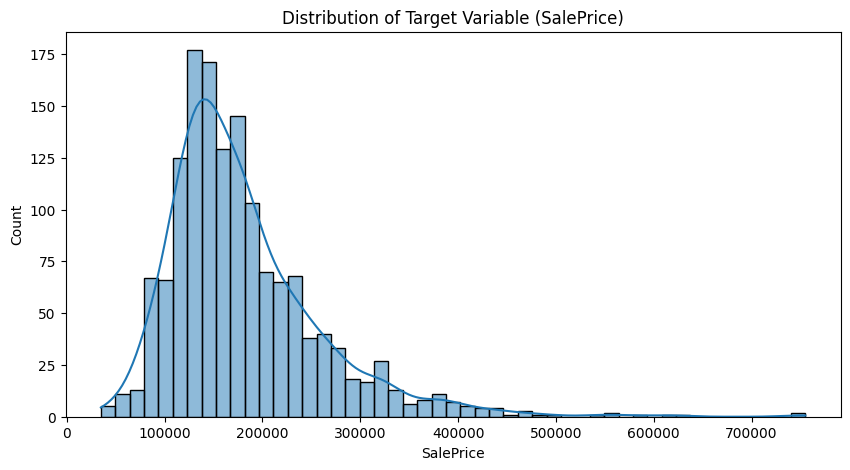

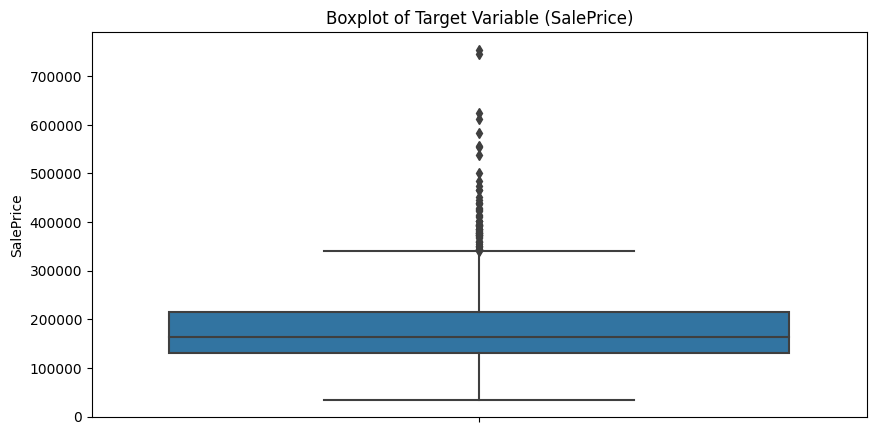

In [16]:
# target variable is 'SalePrice'
plt.figure(figsize=(10, 5))
sns.histplot(updated_df['SalePrice'], kde=True)
plt.title('Distribution of Target Variable (SalePrice)')
plt.show()

# Boxplot to check for outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=updated_df, y='SalePrice')
plt.title('Boxplot of Target Variable (SalePrice)')
plt.show()

* We can observe that the data is skewed to the right

In [17]:
# Skew and kurt
print("Skewness: %f" % updated_df['SalePrice'].skew())
print("Kurtosis: %f" % updated_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


**Observation**

* Here we can observe that there are few outliers in the distribution of the houses salesprice and the salesprice is skwed to the right.

**Distribution of the categorical columns**

In [18]:
# List of categorical columns
categorical_cols = updated_df.select_dtypes(include='object').columns

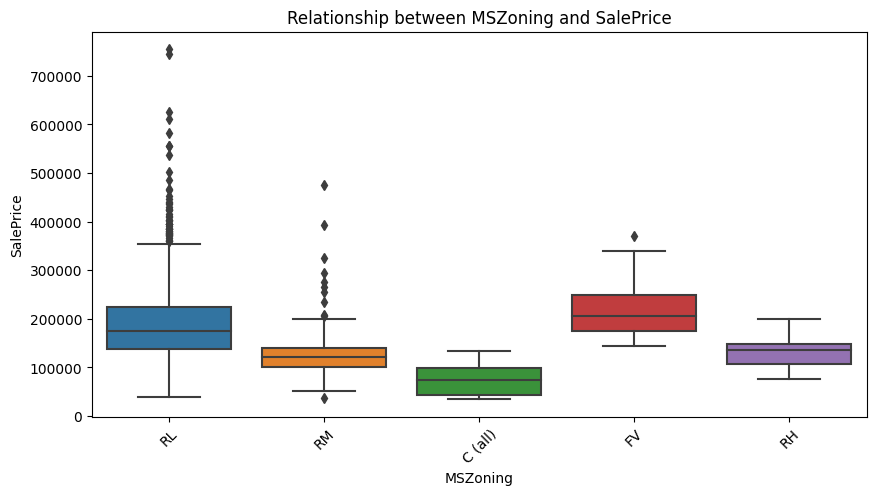

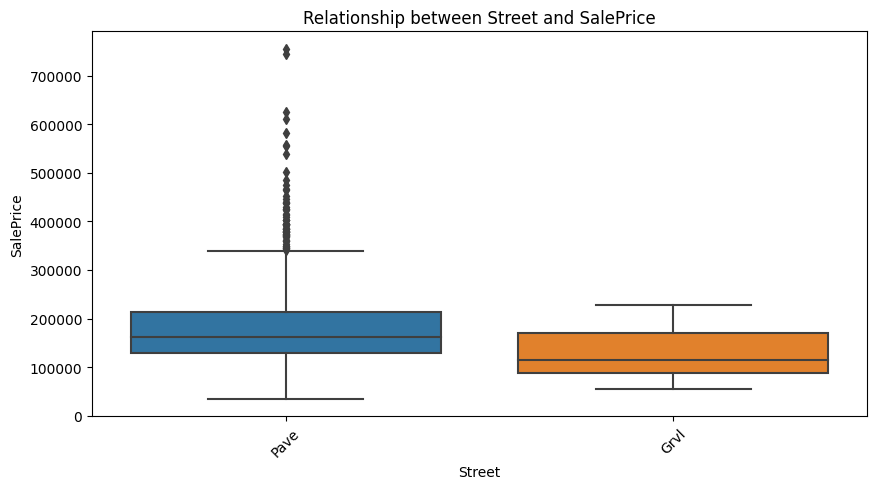

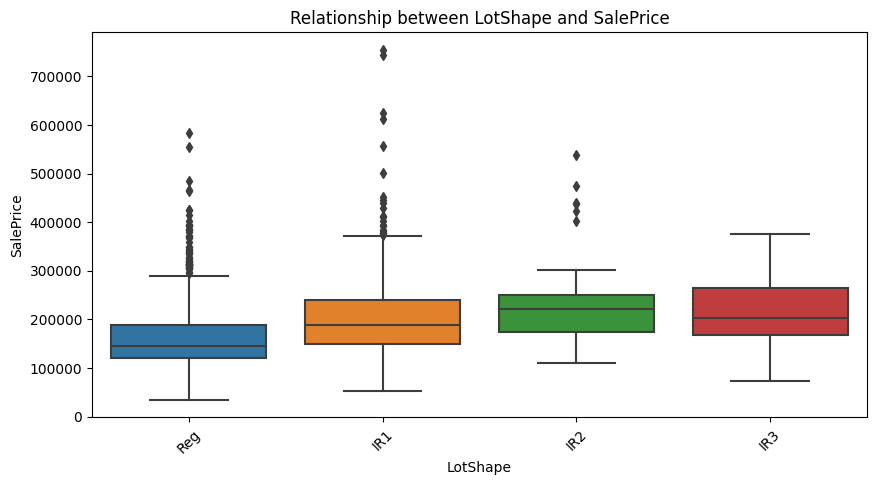

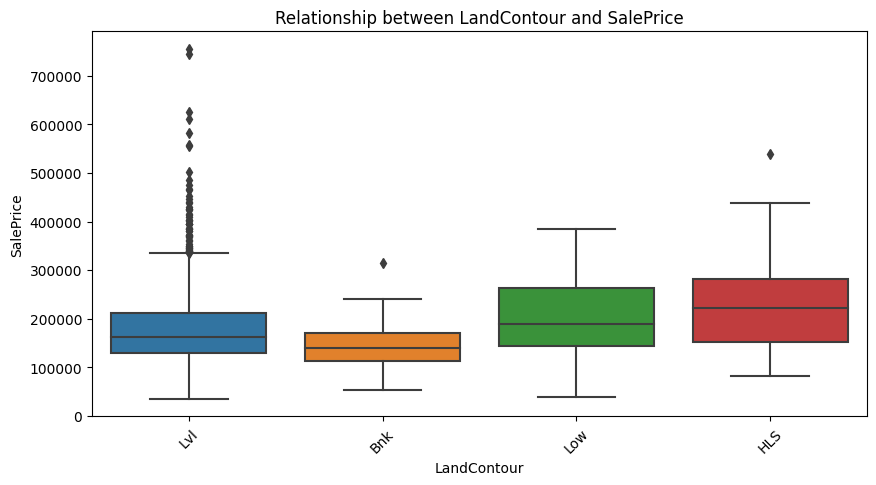

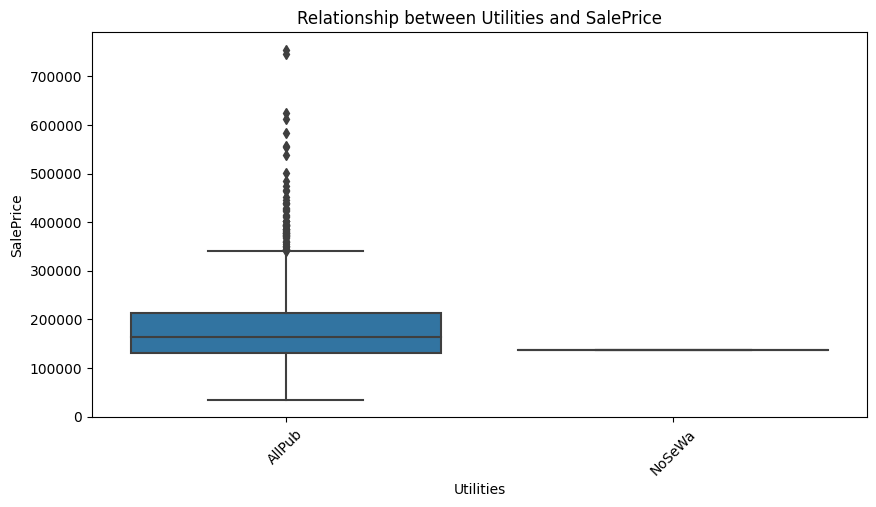

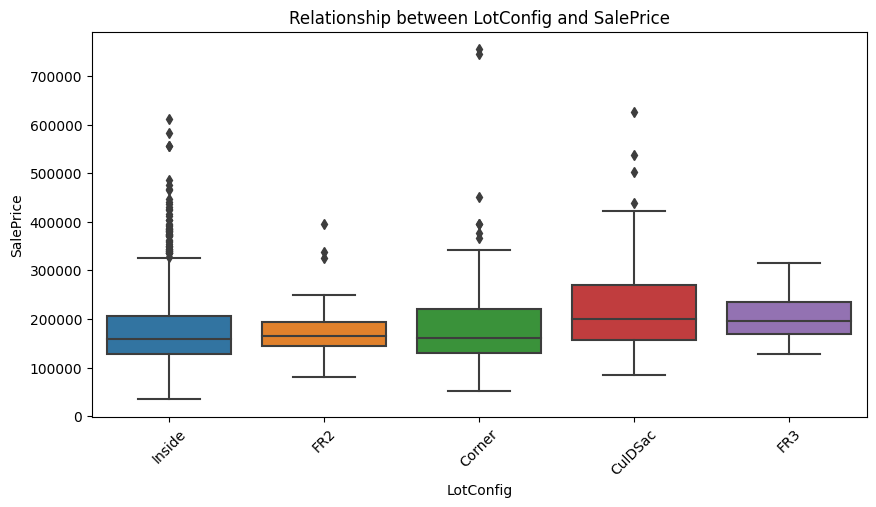

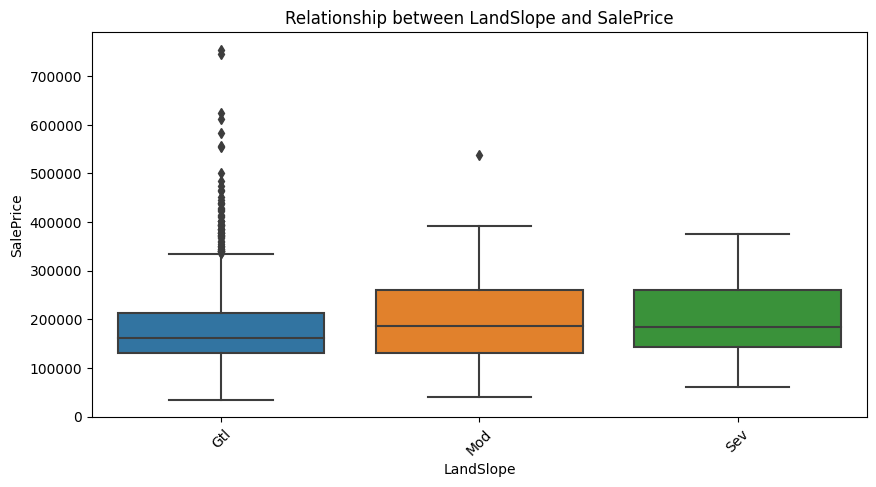

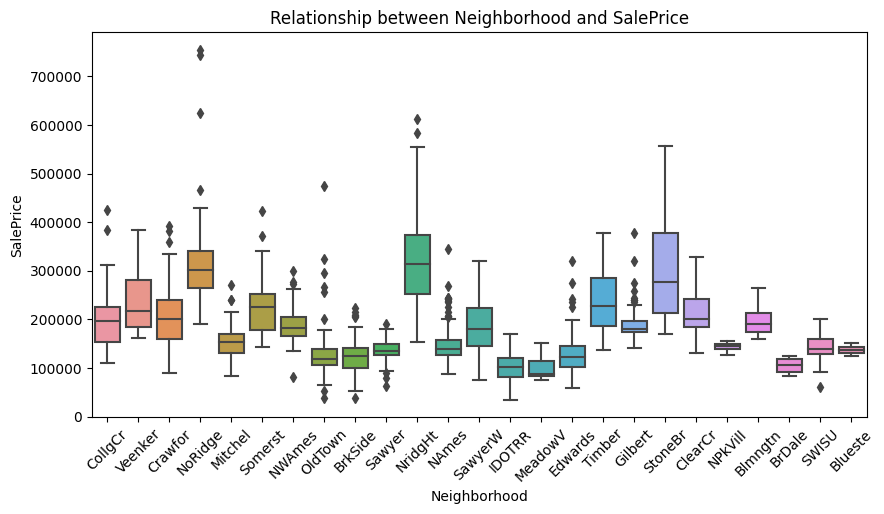

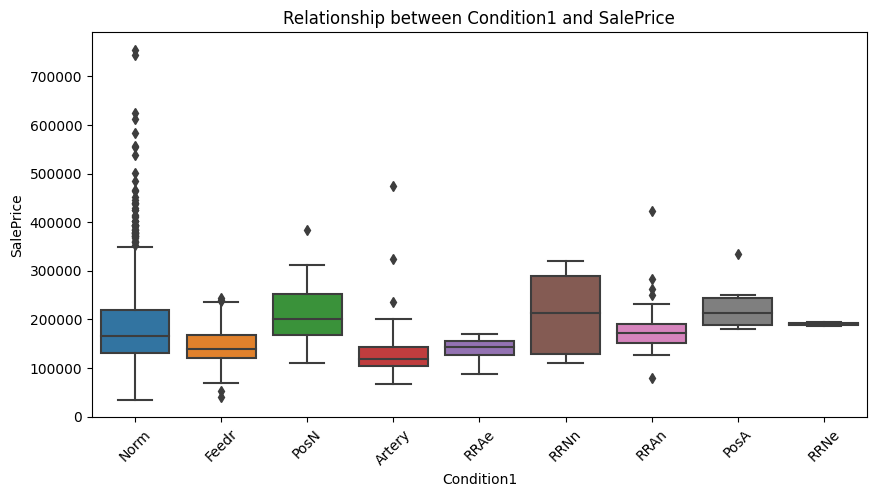

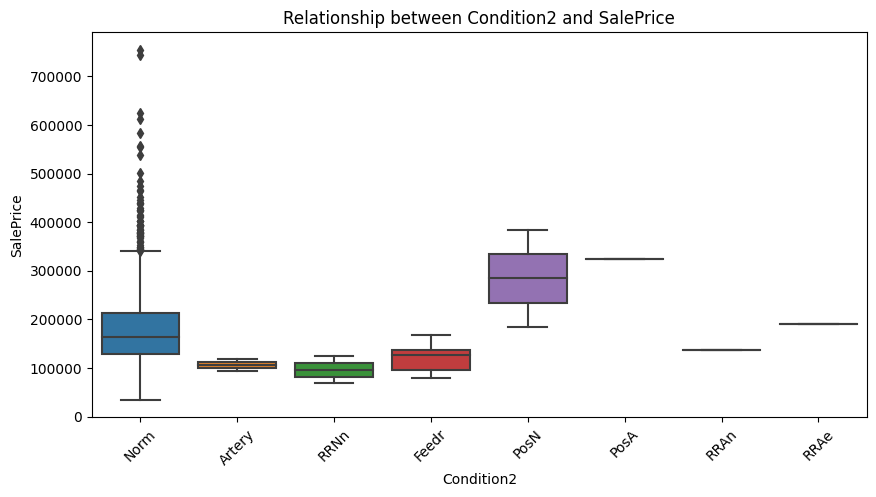

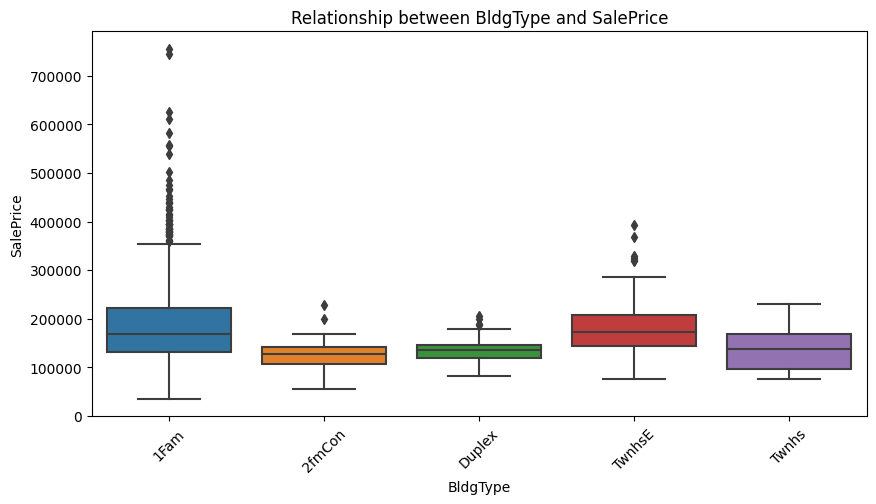

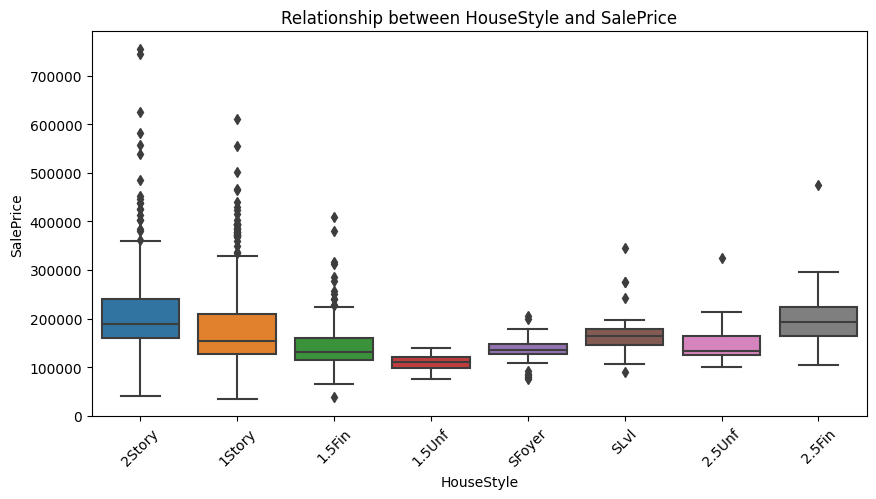

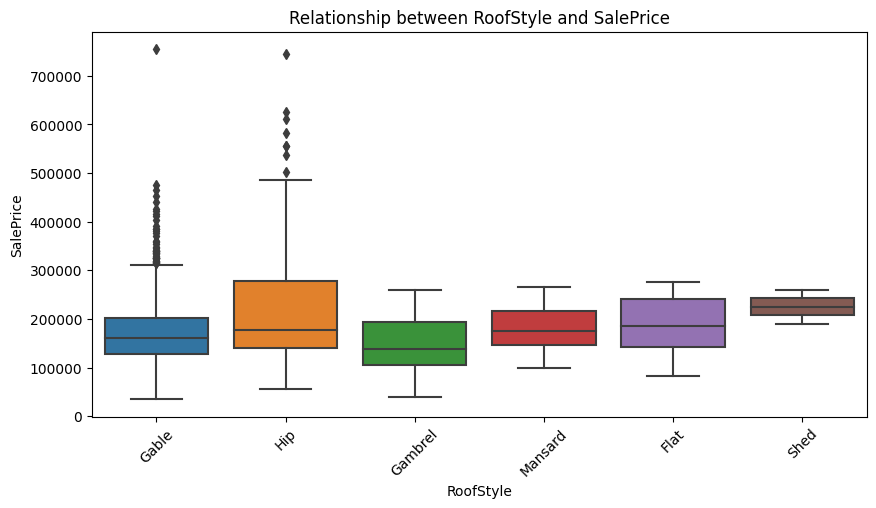

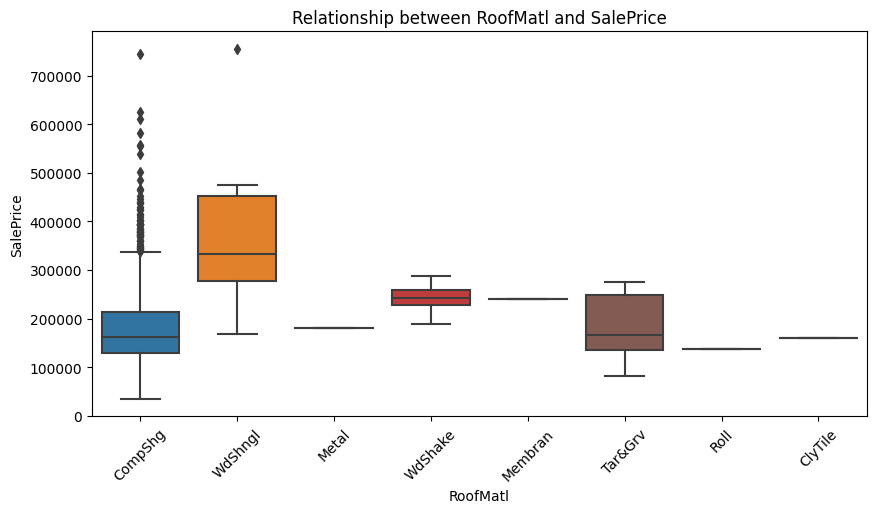

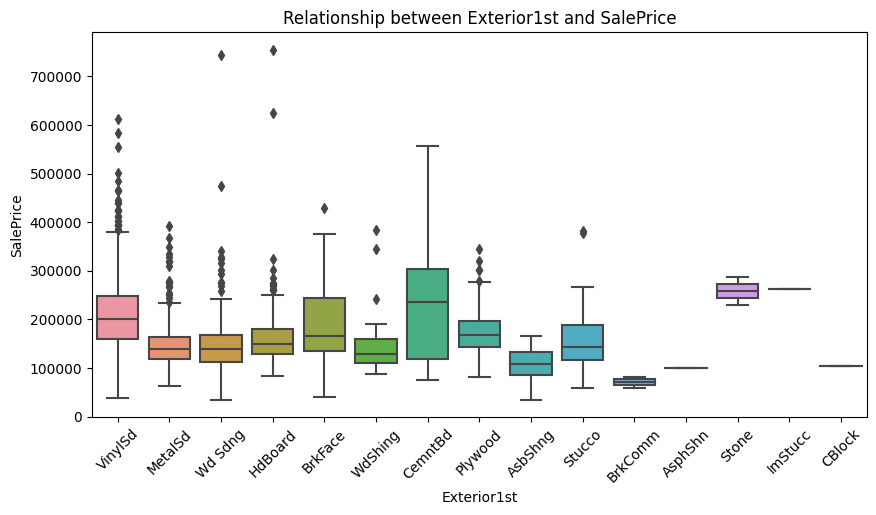

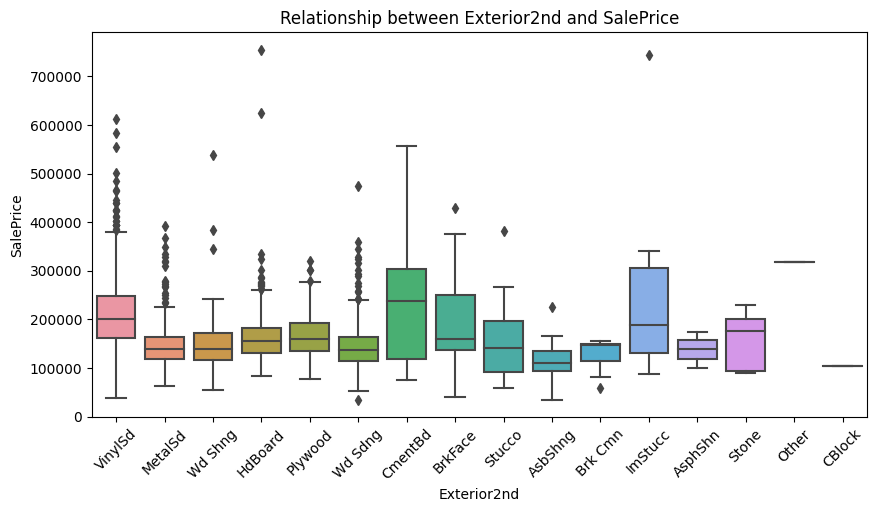

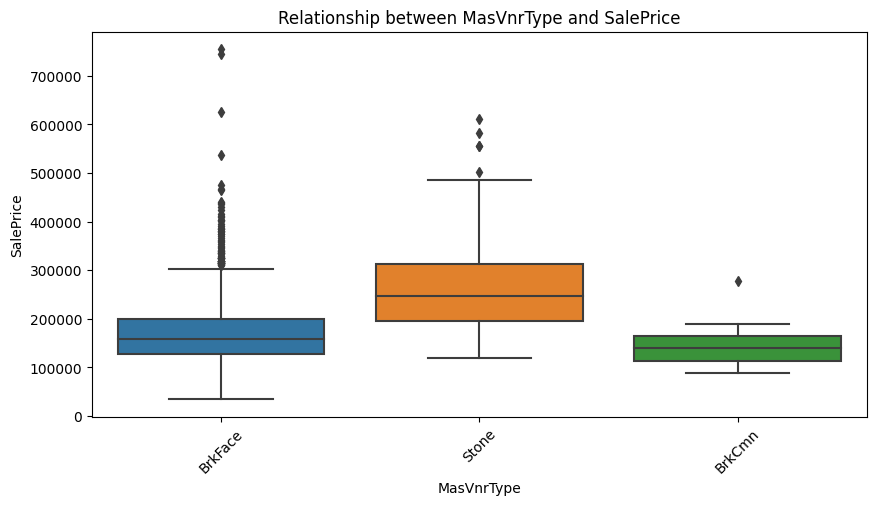

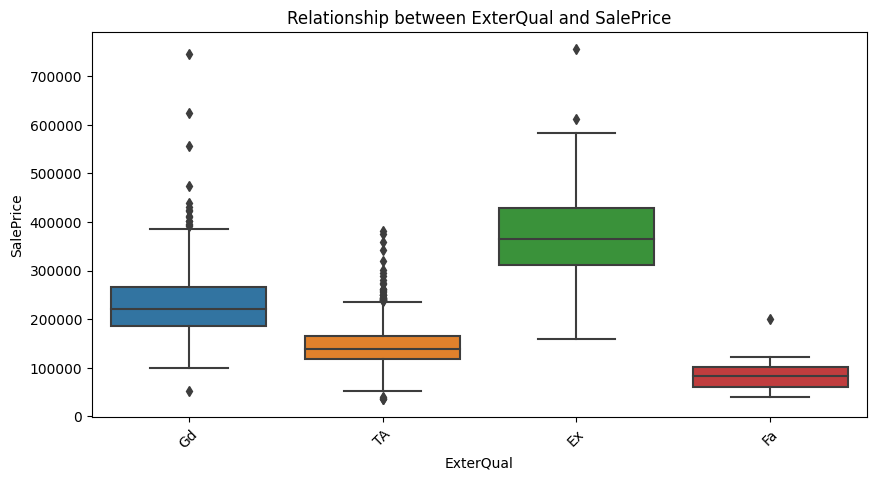

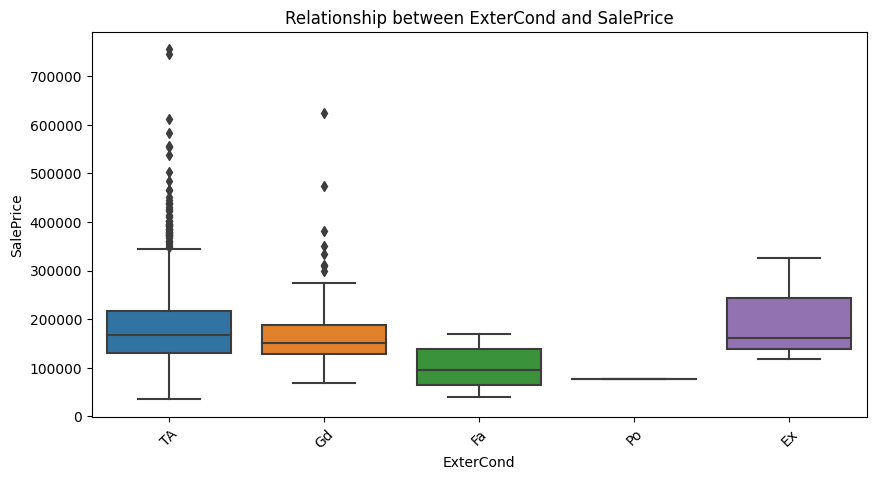

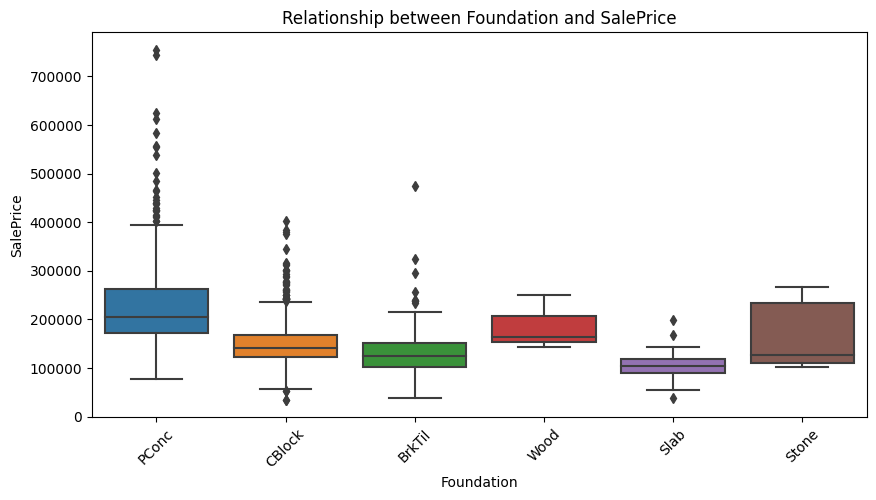

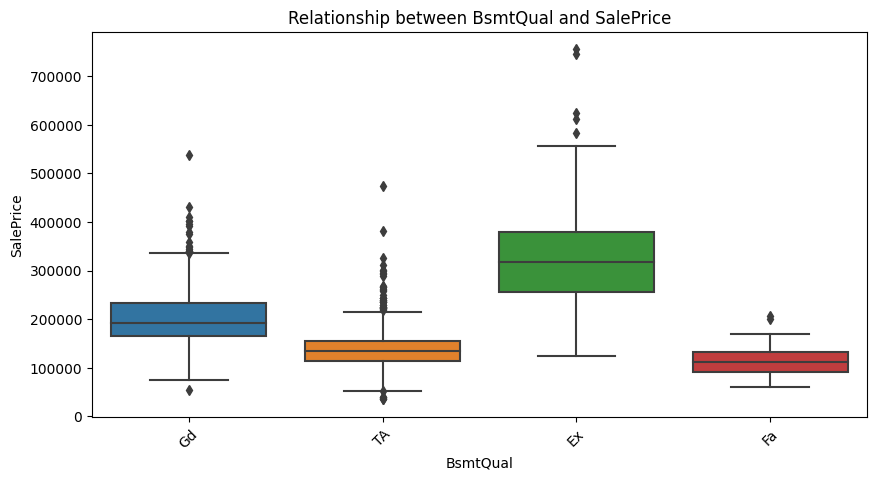

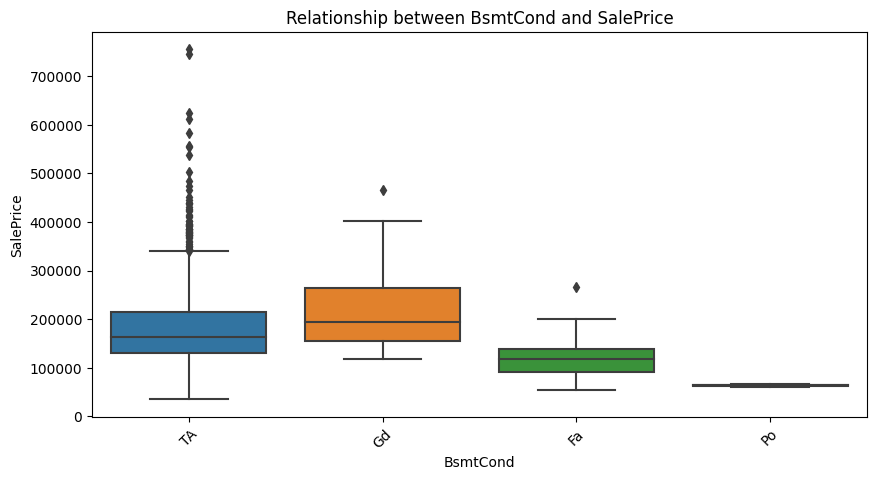

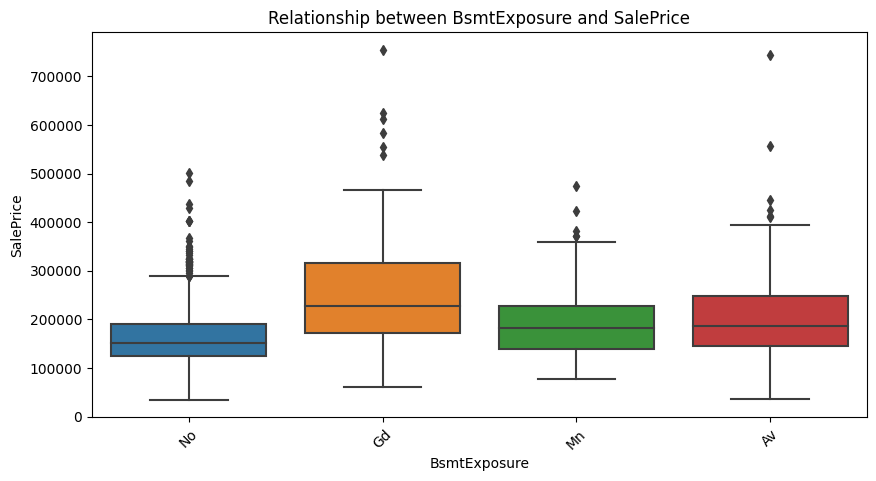

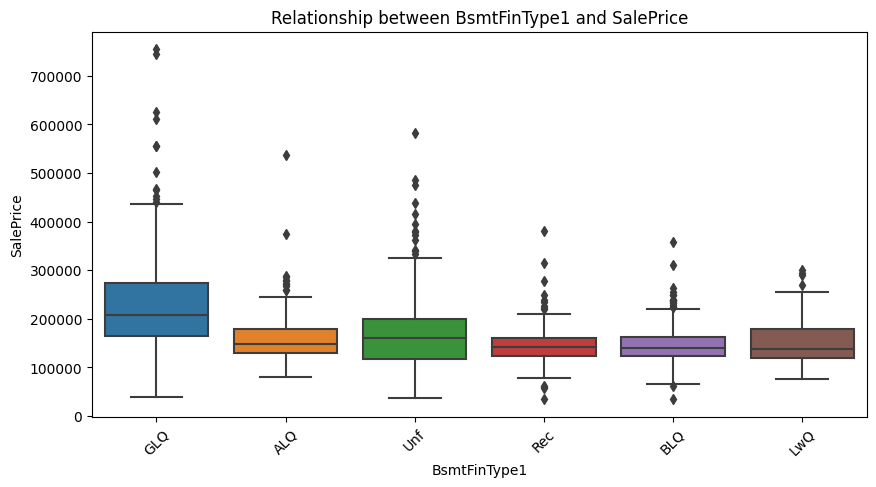

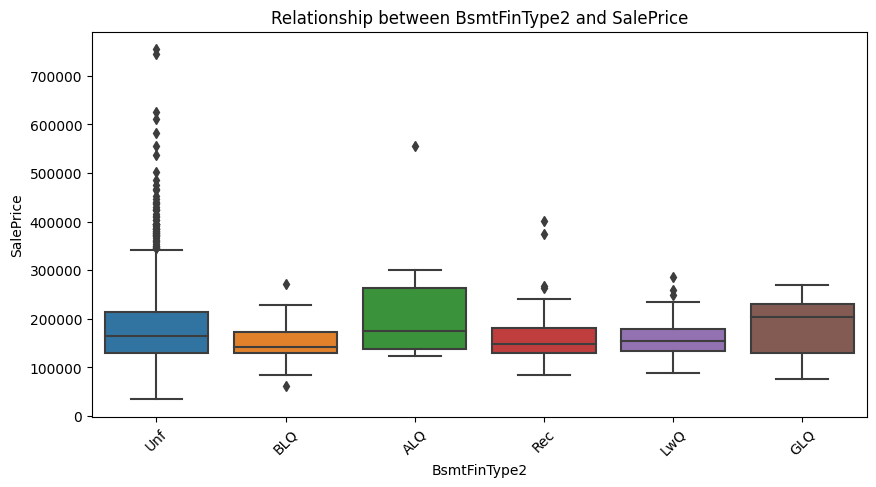

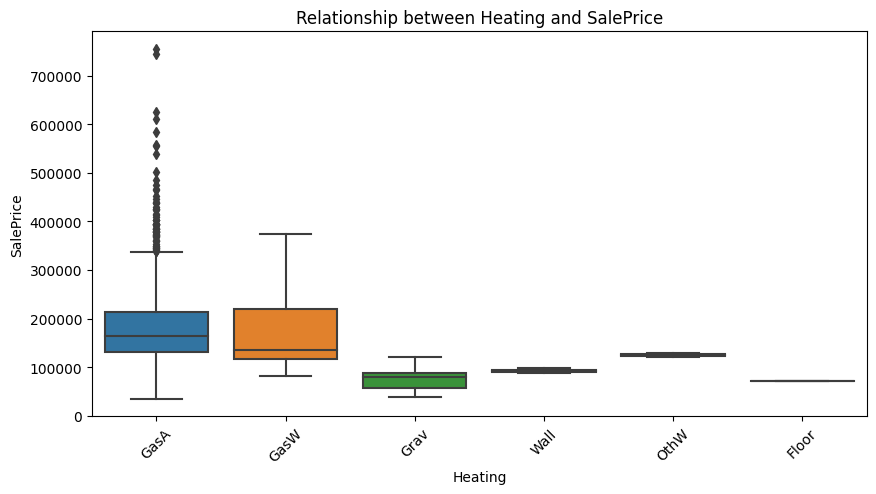

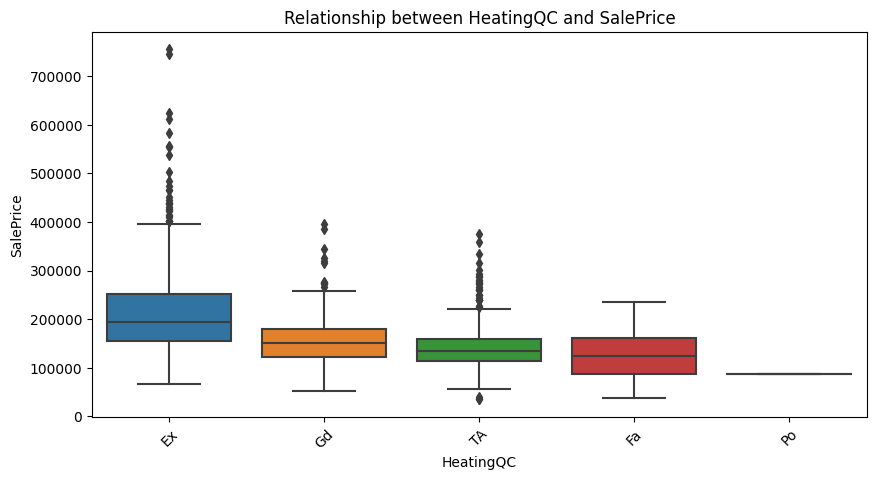

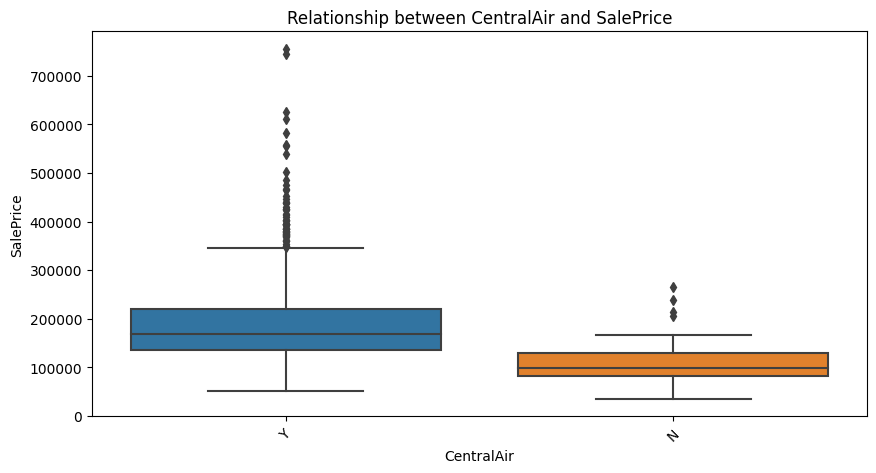

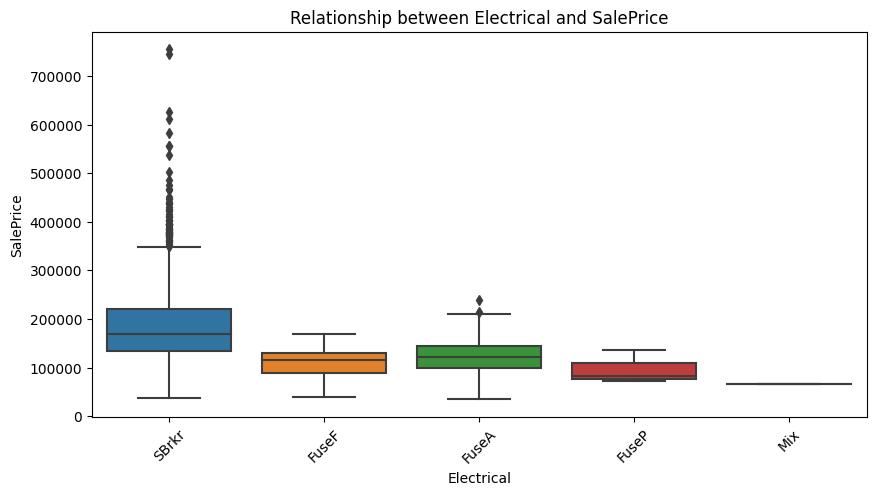

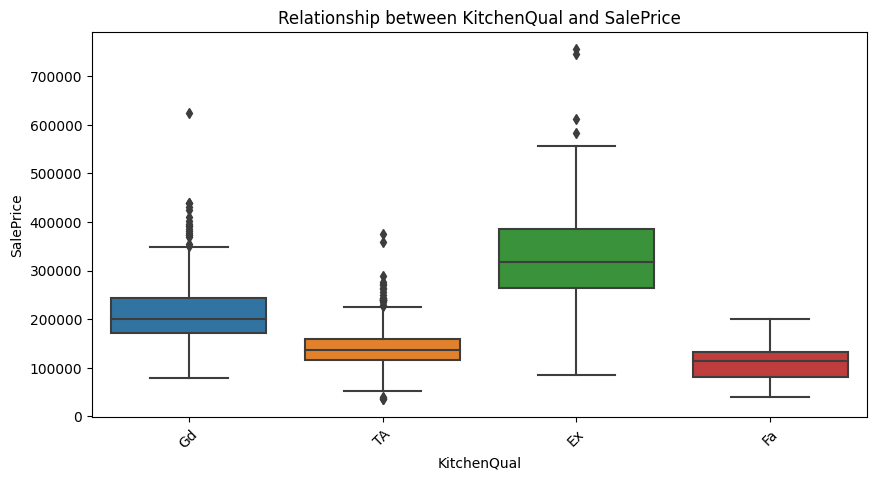

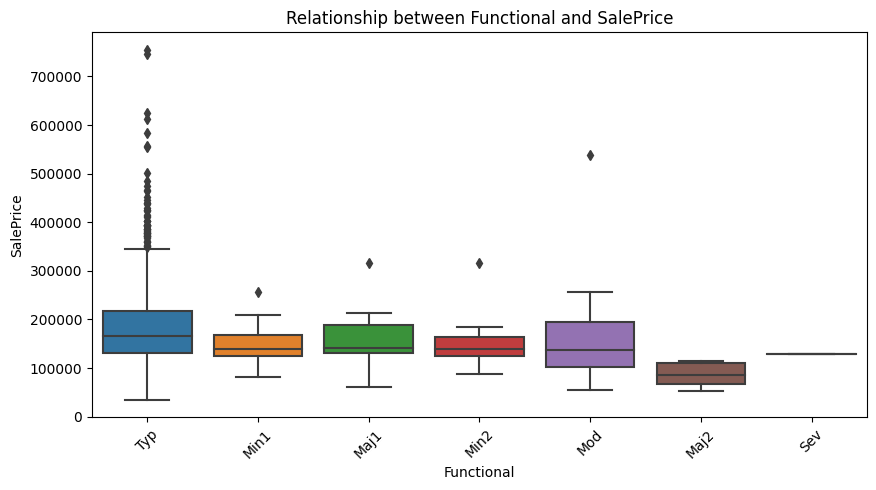

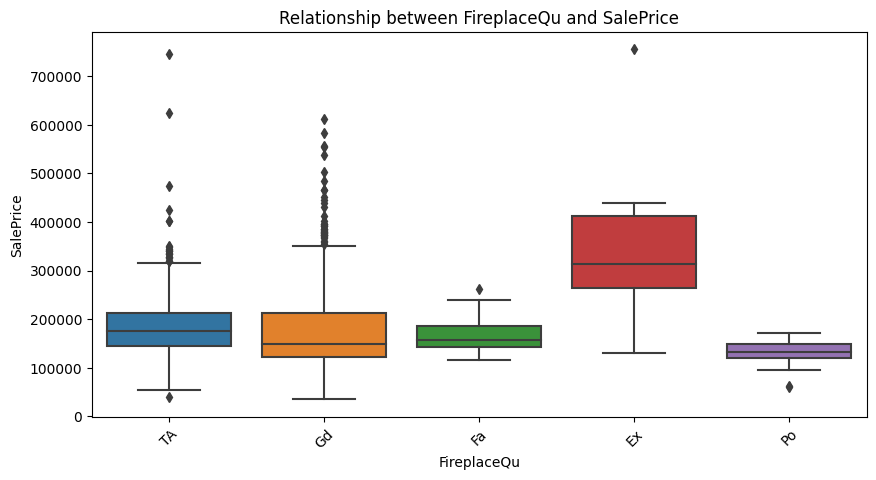

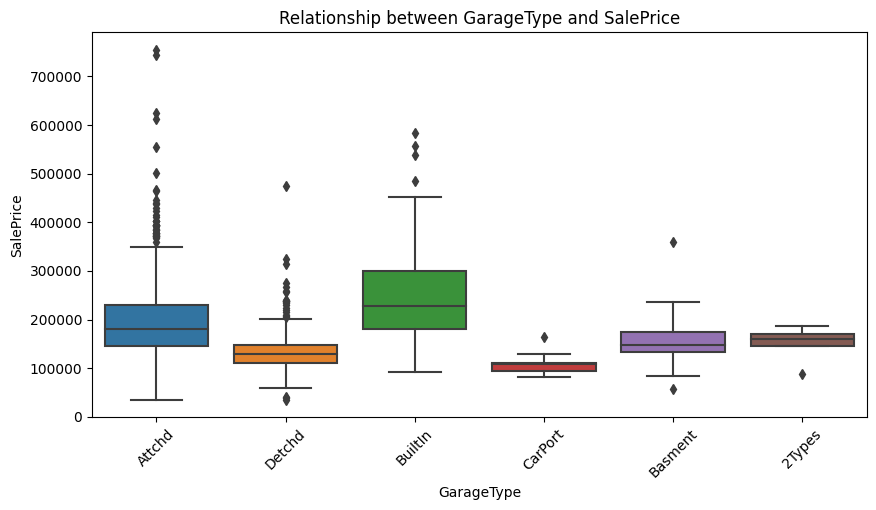

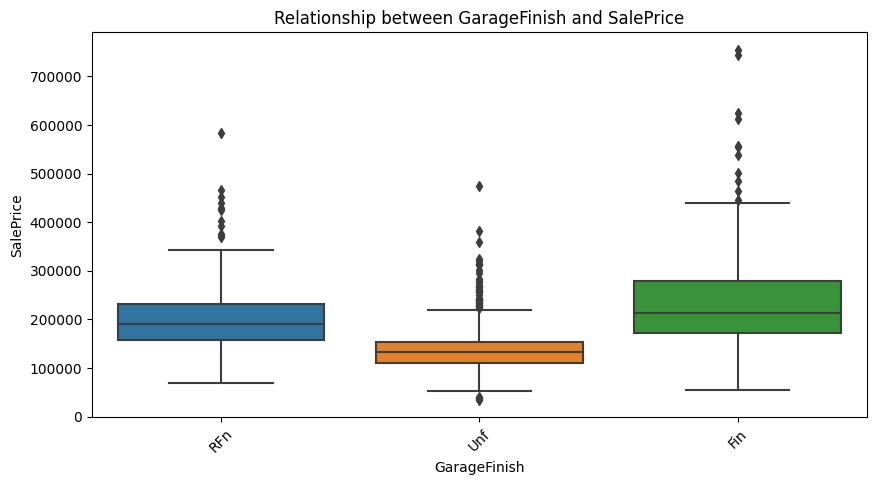

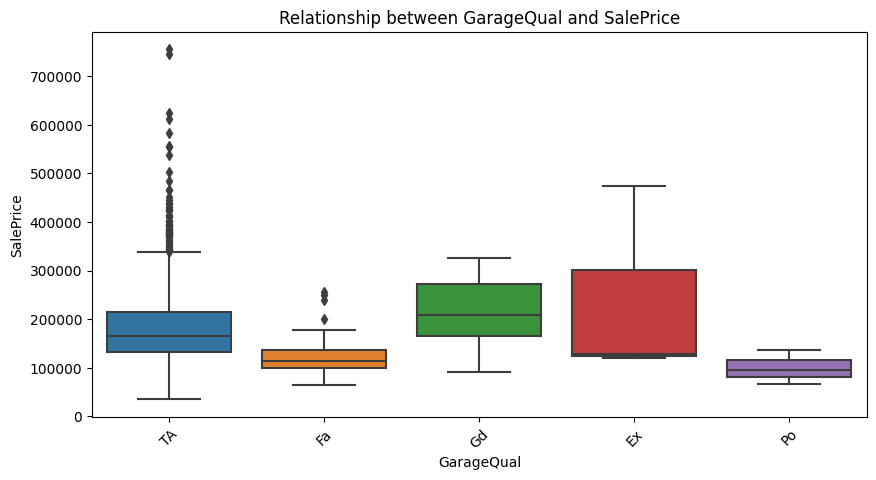

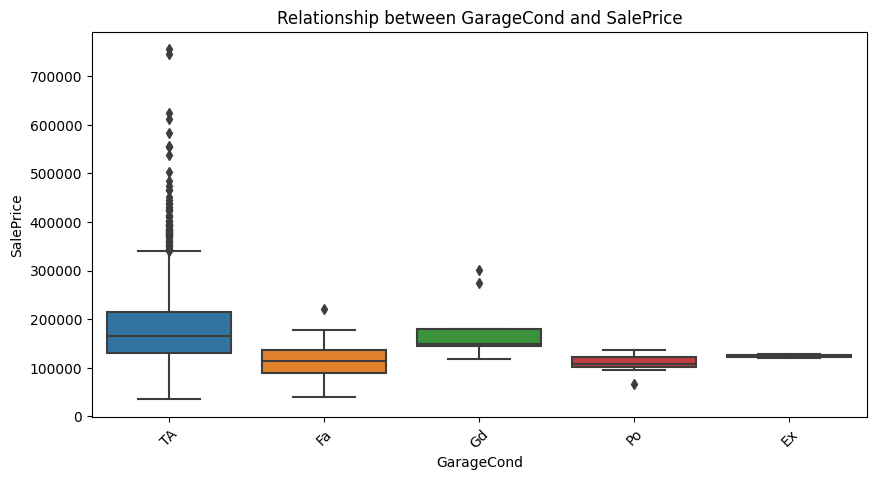

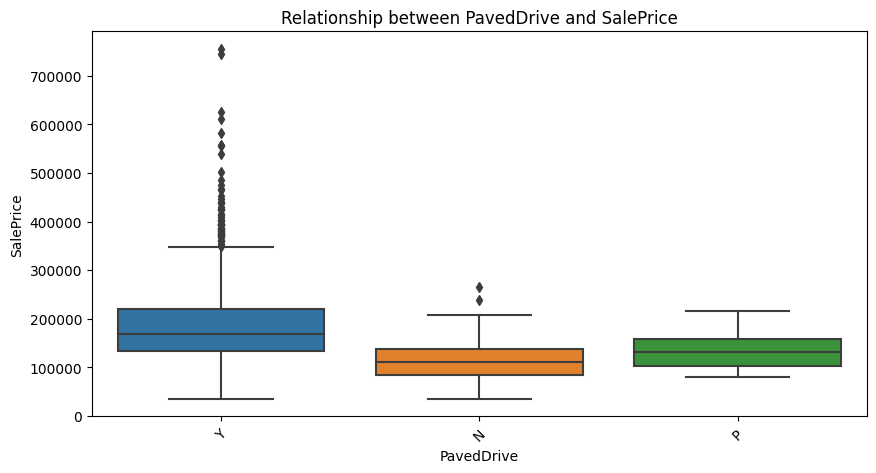

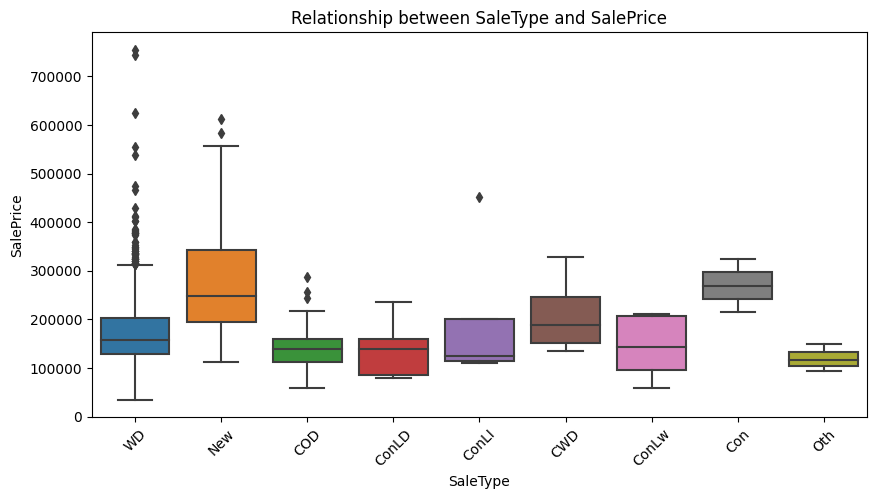

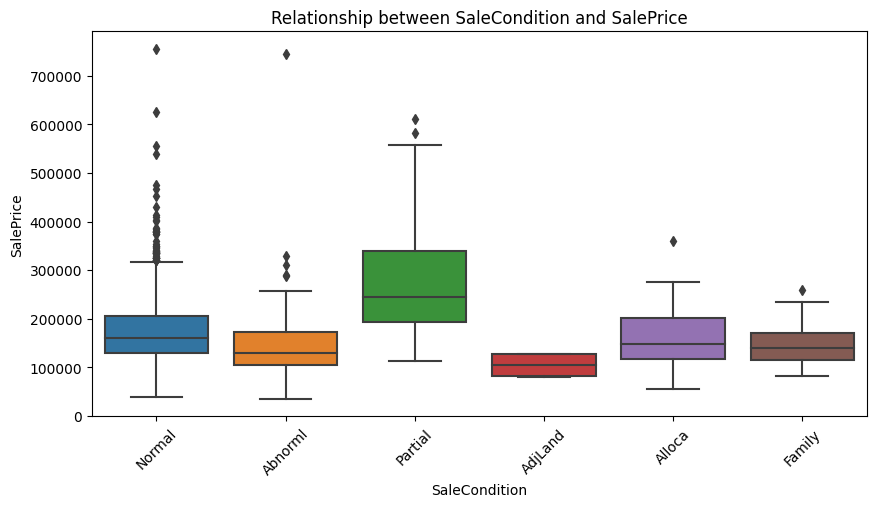

In [19]:
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=updated_df, x=col, y='SalePrice')
    plt.xticks(rotation=45)
    plt.title(f'Relationship between {col} and SalePrice')
    plt.show()

**Observation:**
* From the categories we can observe that there are outliers in the data and it can be handled to make the model perform better.

**Handling the outliers**

*Check for influential point in the outliers*

In [20]:
# Select only numerical columns for influence analysis
numerical_cols = updated_df.select_dtypes(include=[np.number]).columns.drop("SalePrice")
X = updated_df[numerical_cols]
# X = sm.add_constant(X)
y = updated_df["SalePrice"]
model = sm.OLS(y, X).fit()
influence = model.get_influence()

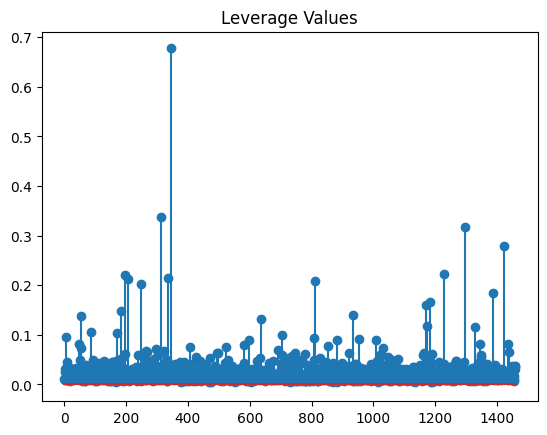

In [21]:
# Leverage values
leverage = influence.hat_matrix_diag
plt.stem(leverage)
plt.title("Leverage Values")
plt.show()

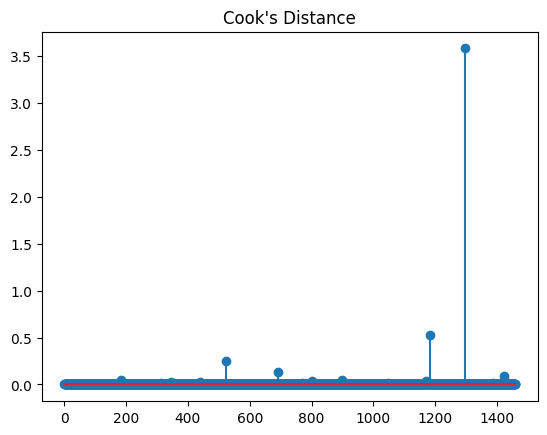

In [22]:
cooks_d = influence.cooks_distance[0]
plt.stem(cooks_d)
plt.title("Cook's Distance")
plt.show()

**Steps to Identify and Remove Outliers Without Affecting Influential Points**
1. Standardized Residuals to Identify Outliers
    * Standardized residuals indicate how far each observation is from the fitted model, scaled by its standard deviation.
    * Rule of thumb:
    |Standardized Residual| > 3 → Likely an outlier.

2. Exclude Observations Based on Residual Threshold
    * Filter the dataset to remove points flagged as outliers based on standardized residuals.
  
3. Ensure Influential Points Remain
    * Influential points are identified using Cook's Distance:
    * Observations with Cook’s Distance > 4/n are flagged as influential.
    * Keep these points in the dataset even if they overlap with outliers.

In [23]:
# Compute standardized residuals
influence = OLSInfluence(model)  # Analyze model influence
standardized_residuals = influence.resid_studentized_internal

# Flag outliers: Standardized residuals greater than 3 or less than -3
outliers = np.where(np.abs(standardized_residuals) > 3)[0]
print(f"Outlier indices: {outliers}")

Outlier indices: [ 178  185  440  473  523  632  688  691  769  798  803  898 1046 1169
 1181 1182 1243 1298 1324]


In [24]:
# Compute Cook's Distance
cooks_distance = influence.cooks_distance[0]

# Flag influential points: Cook's Distance > 4/n
n = len(updated_df)
influential_points = np.where(cooks_distance > (4 / n))[0]
print(f"Influential point indices: {influential_points}")

Influential point indices: [   5    8   48   66   70   88  178  185  197  218  231  278  291  297
  313  335  346  375  378  440  473  496  520  523  527  529  533  588
  591  608  632  662  664  666  678  688  691  716  769  774  798  803
  807  809  898  944 1024 1030 1031 1046 1048 1068 1142 1169 1170 1173
 1181 1182 1211 1230 1243 1298 1310 1324 1349 1386 1415 1423 1437 1440]


In [25]:
# Combine logic: Keep influential points even if they are outliers
final_indices_to_keep = list(set(updated_df.index) - set(outliers) | set(influential_points))

# Create a cleaned dataset
updated_df_final = updated_df.loc[final_indices_to_keep].reset_index(drop=True)

print(f"Final dataset shape: {updated_df_final.shape}")

Final dataset shape: (1460, 75)


In [26]:
# Print the summary to inspect model performance
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              1385.
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                        0.00
Time:                        11:31:10   Log-Likelihood:                         -17322.
No. Observations:                1460   AIC:                                  3.471e+04
Df Residuals:                    1427   BIC:                                  3.488e+04
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

**Observation:**

* From the fitted model's summary we can observe that certain variables have high std err, which can signal problems such as multicollinearity or that the variable is not strongly related to the target.

**Diagnose Multicollinearity:**

* Compute the Variance Inflation Factor (VIF) for all variables.
* Rule of Thumb: Drop variables with VIF > 10, as they contribute to multicollinearity.

**Evaluate Statistical Significance:**

* Focus on variables with low p-values (< 0.05 or 0.01, depending on the context). High p-values suggest that the variable is not significantly contributing to the prediction.

In [27]:
X = updated_df_final[numerical_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


          feature           VIF
0      MSSubClass  4.620736e+00
1     LotFrontage  1.543412e+01
2         LotArea  2.628444e+00
3     OverallQual  6.659518e+01
4     OverallCond  4.085588e+01
5       YearBuilt  1.728937e+04
6    YearRemodAdd  2.072810e+04
7      MasVnrArea  1.842162e+00
8      BsmtFinSF1           inf
9      BsmtFinSF2           inf
10      BsmtUnfSF           inf
11    TotalBsmtSF           inf
12       1stFlrSF           inf
13       2ndFlrSF           inf
14   LowQualFinSF           inf
15      GrLivArea           inf
16   BsmtFullBath  3.694266e+00
17   BsmtHalfBath  1.216944e+00
18       FullBath  2.639028e+01
19       HalfBath  3.418088e+00
20   BedroomAbvGr  3.096029e+01
21   KitchenAbvGr  3.752075e+01
22   TotRmsAbvGrd  8.335416e+01
23     Fireplaces  2.977728e+00
24     GarageCars  3.621995e+01
25     GarageArea  3.082488e+01
26     WoodDeckSF  1.893865e+00
27    OpenPorchSF  1.818352e+00
28  EnclosedPorch  1.446732e+00
29      3SsnPorch  1.036486e+00
30    Sc

**Problematic Features (High VIFs):**
* Features like YearBuilt, YearRemodAdd, OverallQual, OverallCond, TotRmsAbvGrd, and several others have alarmingly high or infinite VIF values, indicating severe multicollinearity.

**Feature Engineering**

* Basement Features: Instead of using BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, and TotalBsmtSF, you can combine them

* Floor Area Features: Combine 1stFlrSF and 2ndFlrSF into a single TotalFlrSF feature

* Bathrooms: Combine BsmtFullBath, BsmtHalfBath, FullBath, and HalfBath into a TotalBaths feature

* Age of the House: Instead of YearBuilt and YearRemodAdd, calculate the age at the time of sale

--* Room Ratios: Calculate ratios such as:

      RoomsPerArea = TotRmsAbvGrd / GrLivArea
  
      BedroomsPerRoom = BedroomAbvGr / TotRmsAbvGrd
  

* Convert continuous variables into categorical bins where appropriate to reduce noise:
  
      LotFrontage

      GrLivArea


* Outdoor Living Area: Sum up WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, and ScreenPorch

* Garage Features: Combine GarageCars and GarageArea into a single metric

* Create interaction terms for features that might work well together:

      Quality and Area

      Garage Features

In [28]:
X.loc[:, "BsmtTotalFinishedSF"] = X["BsmtFinSF1"] + X["BsmtFinSF2"]

X.loc[:, "TotalFlrSF"] = X["1stFlrSF"] + X["2ndFlrSF"]

X.loc[:, "TotalHouseBaths"] = (X["BsmtFullBath"] + (0.5 * X["BsmtHalfBath"]) +
    X["FullBath"] + (0.5 * X["HalfBath"]))

X.loc[:, "Age"] = X["YrSold"] - X["YearBuilt"]

X.loc[:, "YearsSinceRemodel"] = X["YrSold"] - X["YearRemodAdd"]

X.loc[:, "LotFrontageBin"] = pd.qcut(X["LotFrontage"], q=5, labels=False)

X.loc[:, "GrLivAreaBin"] = pd.qcut(X["GrLivArea"], q=5, labels=False)

X.loc[:, "TotalHouseBathsBin"] = pd.qcut(X["TotalHouseBaths"], q=5, labels=False)

X.loc[:, "OutdoorLivingSF"] = X["WoodDeckSF"] + X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]

X.loc[:, "GarageEfficiency"] = X["GarageArea"] / (X["GarageCars"] + 1)

X.loc[:, "QualArea"] = X["OverallQual"] * X["GrLivArea"]

X.loc[:, "OverallQualCond"] = X["OverallQual"] * X["OverallCond"]

X.loc[:, "TotalRooms"] = X["TotRmsAbvGrd"] + X["BedroomAbvGr"] + X["KitchenAbvGr"]

/tmp/ipykernel_30/570233161.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, "BsmtTotalFinishedSF"] = X["BsmtFinSF1"] + X["BsmtFinSF2"]
/tmp/ipykernel_30/570233161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, "TotalFlrSF"] = X["1stFlrSF"] + X["2ndFlrSF"]
/tmp/ipykernel_30/570233161.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [29]:
X = X.drop(["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"], axis=1)
X = X.drop(["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"], axis=1)
X = X.drop(["1stFlrSF", "2ndFlrSF"], axis=1)
X = X.drop("LotFrontage", axis=1)
X = X.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath","TotalHouseBaths"], axis=1)
X = X.drop(["GarageArea", "GarageCars"], axis=1)
X = X.drop(["YearBuilt", "YearRemodAdd"], axis=1)
X = X.drop(["OverallQual", "OverallCond","GrLivArea"], axis=1)
X = X.drop(["TotRmsAbvGrd", "BedroomAbvGr","KitchenAbvGr"], axis=1)

**Recompute VIF After Engineering**

In [30]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                feature         VIF
0            MSSubClass    3.484464
1               LotArea    2.513274
2            MasVnrArea    1.847246
3          LowQualFinSF    1.235318
4            Fireplaces    2.825113
5              PoolArea    1.124948
6               MiscVal    1.023552
7                MoSold    6.548109
8                YrSold   87.320186
9   BsmtTotalFinishedSF    3.479045
10           TotalFlrSF  255.815546
11                  Age    6.986906
12    YearsSinceRemodel    4.738529
13       LotFrontageBin    3.876692
14         GrLivAreaBin   19.278048
15   TotalHouseBathsBin    6.451243
16      OutdoorLivingSF    2.970005
17     GarageEfficiency   12.920301
18             QualArea   86.560110
19      OverallQualCond   35.879928
20           TotalRooms   70.123538


**Observation**
* From this we can observe that the variance inflation factor has reduced after the feature engineering for many of the features, but still some of the features have a high variance inflation factor

In [31]:
updated_model = sm.OLS(y, X).fit()
print(updated_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              2186.
Date:                Wed, 11 Dec 2024   Prob (F-statistic):                        0.00
Time:                        11:31:10   Log-Likelihood:                         -17324.
No. Observations:                1460   AIC:                                  3.469e+04
Df Residuals:                    1439   BIC:                                  3.480e+04
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

Here’s the revised table comparing the models before and after feature engineering:

| **Metric**                | **After Feature Engineering** | **Before Feature Engineering** | **Comment**                                             |
|---------------------------|-------------------------------|---------------------------------|---------------------------------------------------------|
| **R-squared (uncentered)**| 0.970                         | 0.970                           | No noticeable change in explained variance.             |
| **Adj. R-squared**        | 0.969                         | 0.969                           | No significant difference.                              |
| **F-statistic**           | 2186                          | 1385                            | Improved model fit after feature engineering.           |
| **AIC**                   | 34,690                        | 34,710                          | Marginally lower, indicating a slightly better model.   |
| **BIC**                   | 34,800                        | 34,880                          | Improvement after feature engineering.                  |
| **Number of Predictors**  | 21                            | 33                              | Feature engineering reduced dimensionality.             |
| **Significant Coefficients**| Many features remain significant | Many features significant     | Some new interactions or engineered features are significant (e.g., `LotFrontageBin`). |
| **Condition Number**      | 3.43e+04                      | 1.24e+16                        | Significant improvement in multicollinearity.           |

**Conclusion:**

The model's performance improved slightly after feature engineering. While the improvement in metrics like R-squared is small, the decrease in AIC/BIC and the higher F-statistic suggest the changes made the model more efficient and robust. The feature-engineered model is preferable for practical use.

**Updating these changes into the dataframe**

In [32]:
updated_df_final.loc[:, "BsmtTotalFinishedSF"] = updated_df_final["BsmtFinSF1"] + updated_df_final["BsmtFinSF2"]

updated_df_final.loc[:, "TotalFlrSF"] = updated_df_final["1stFlrSF"] + updated_df_final["2ndFlrSF"]

updated_df_final.loc[:, "TotalHouseBaths"] = (updated_df_final["BsmtFullBath"] + (0.5 * updated_df_final["BsmtHalfBath"]) +
    updated_df_final["FullBath"] + (0.5 * updated_df_final["HalfBath"]))

updated_df_final.loc[:, "Age"] = updated_df_final["YrSold"] - updated_df_final["YearBuilt"]

updated_df_final.loc[:, "YearsSinceRemodel"] = updated_df_final["YrSold"] - updated_df_final["YearRemodAdd"]

updated_df_final.loc[:, "LotFrontageBin"] = pd.qcut(updated_df_final["LotFrontage"], q=5, labels=False)

updated_df_final.loc[:, "GrLivAreaBin"] = pd.qcut(updated_df_final["GrLivArea"], q=5, labels=False)

updated_df_final.loc[:, "TotalHouseBathsBin"] = pd.qcut(updated_df_final["TotalHouseBaths"], q=5, labels=False)

updated_df_final.loc[:, "OutdoorLivingSF"] = updated_df_final["WoodDeckSF"] + updated_df_final["OpenPorchSF"] + updated_df_final["EnclosedPorch"] + updated_df_final["3SsnPorch"] +updated_df_final["ScreenPorch"]

updated_df_final.loc[:, "GarageEfficiency"] = updated_df_final["GarageArea"] / (updated_df_final["GarageCars"] + 1)

updated_df_final.loc[:, "QualArea"] = updated_df_final["OverallQual"] * updated_df_final["GrLivArea"]

updated_df_final.loc[:, "OverallQualCond"] = updated_df_final["OverallQual"] * updated_df_final["OverallCond"]

updated_df_final.loc[:, "TotalRooms"] =updated_df_final["TotRmsAbvGrd"] + updated_df_final["BedroomAbvGr"] + updated_df_final["KitchenAbvGr"]

In [33]:
updated_df_final = updated_df_final.drop(["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"], axis=1)
updated_df_final = updated_df_final.drop(["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"], axis=1)
updated_df_final = updated_df_final.drop(["1stFlrSF", "2ndFlrSF"], axis=1)
updated_df_final = updated_df_final.drop("LotFrontage", axis=1)
updated_df_final = updated_df_final.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath","TotalHouseBaths"], axis=1)
updated_df_final = updated_df_final.drop(["GarageArea", "GarageCars"], axis=1)
updated_df_final = updated_df_final.drop(["YearBuilt", "YearRemodAdd"], axis=1)
updated_df_final = updated_df_final.drop(["OverallQual", "OverallCond","GrLivArea"], axis=1)
updated_df_final = updated_df_final.drop(["TotRmsAbvGrd", "BedroomAbvGr","KitchenAbvGr"], axis=1)

In [34]:
updated_df_final.head(3)

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,Age,YearsSinceRemodel,LotFrontageBin,GrLivAreaBin,TotalHouseBathsBin,OutdoorLivingSF,GarageEfficiency,QualArea,OverallQualCond,TotalRooms
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,5,5,2,3,4,61,182.666667,11970,35,12
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,31,31,3,1,2,298,153.333333,7572,48,10
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,7,6,2,3,4,42,202.666667,12502,35,10


**Handling the skew**

*As we observed earlier that the target variable "Salesprice" is skewed we shall check for skew in the explanatory variables*

* From the earlier observation we can observe that the "Salesprice" is skewed to the right. Hence applying log(1+x) transformation

In [35]:
# log(1+x) transform
updated_df_final["SalePrice"] = np.log1p(updated_df_final["SalePrice"])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


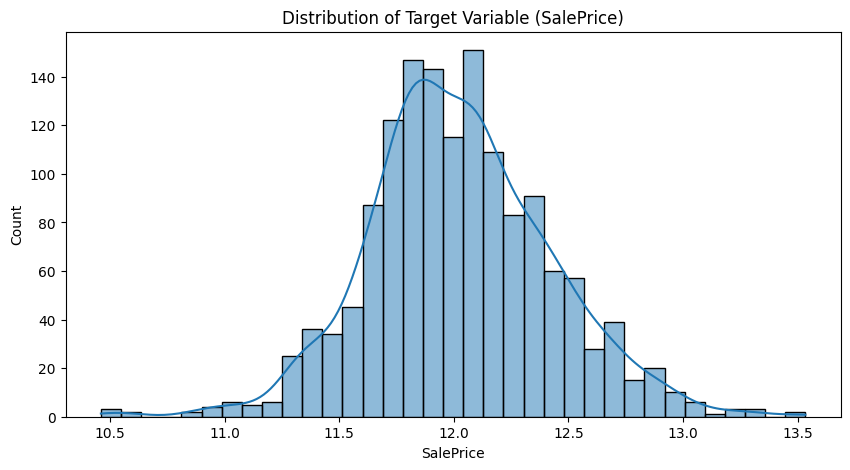

In [36]:
# target variable is 'SalePrice'
plt.figure(figsize=(10, 5))
sns.histplot(updated_df_final['SalePrice'], kde=True)
plt.title('Distribution of Target Variable (SalePrice)')
plt.show()

In [37]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in updated_df_final.columns:
    if updated_df_final[i].dtype in numeric_dtypes:
        numeric.append(i)

In [38]:
# Find skewed numerical features
skew_features = updated_df_final[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

# Check for features for skewness
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(15)

There are 15 numerical features with Skew > 0.5 :


MiscVal                24.451640
PoolArea               14.813135
LotArea                12.195142
LowQualFinSF            9.002080
MasVnrArea              2.674865
QualArea                2.016851
MSSubClass              1.406210
BsmtTotalFinishedSF     1.404517
TotalFlrSF              1.329103
OutdoorLivingSF         1.101180
TotalRooms              0.653972
Fireplaces              0.648898
Age                     0.608404
TotalHouseBathsBin      0.507861
YearsSinceRemodel       0.501973
dtype: float64

**Criteria for Choosing Transformation**

1. **Box-Cox Transformation**:
   - Works well on **moderately skewed** data (skewness (0.5 < {skew} <= 3).
   - Requires **positive values** only.
   - Suitable for features with a **continuous, approximately exponential-like distribution**.

2. **Quantile Transformation**:
   - Ideal for **highly skewed** data (skew > 3).
   - Handles **zero and negative values** (especially with `output_distribution='uniform'`).
   - Useful for datasets with extreme outliers or **non-parametric distributions**.

3. **Non-Skewed Data**:
   - Features with skewness \(\text{skew} \leq 0.5\) are already close to normal and do not require transformation.

---

In [39]:
# Thresholds for skewness classification
high_skew_threshold = 3  # Highly skewed
moderate_skew_threshold = 0.5  # Moderately skewed

# Separate features based on skewness thresholds
high_skew_features = skew_features[skew_features > high_skew_threshold].index
moderate_skew_features = skew_features[
    (skew_features > moderate_skew_threshold) & (skew_features <= high_skew_threshold)
].index

# Print the splits
print("Highly skewed features (Quantile Transformation):", high_skew_features.tolist())
print("Moderately skewed features (Box-Cox Transformation):", moderate_skew_features.tolist())

Highly skewed features (Quantile Transformation): ['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF']
Moderately skewed features (Box-Cox Transformation): ['MasVnrArea', 'QualArea', 'MSSubClass', 'BsmtTotalFinishedSF', 'TotalFlrSF', 'OutdoorLivingSF', 'TotalRooms', 'Fireplaces', 'Age', 'TotalHouseBathsBin', 'YearsSinceRemodel']


In [40]:
# Define a function for Quantile Transformation
def quantile_transform(data, cols, output_distribution='normal', random_state=42):
    qt = QuantileTransformer(output_distribution=output_distribution, random_state=random_state)
    for col in cols:
        if col in data.columns:
            data[col] = qt.fit_transform(data[[col]])
    return data

# Apply Quantile Transformation to highly skewed features
updated_df_final = quantile_transform(updated_df_final, high_skew_features)

# Apply Box-Cox Transformation to moderately skewed features
for col in moderate_skew_features:
    # Ensure column has positive values
    if (updated_df_final[col] <= 0).any():
        updated_df_final[col] = updated_df_final[col] - updated_df_final[col].min() + 1

    # Apply Box-Cox transformation
    try:
        optimal_lambda = boxcox_normmax(updated_df_final[col] + 1)
        updated_df_final[col] = boxcox1p(updated_df_final[col], optimal_lambda)
    except Exception as e:
        print(f"Skipping column '{col}' due to error: {e}")


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

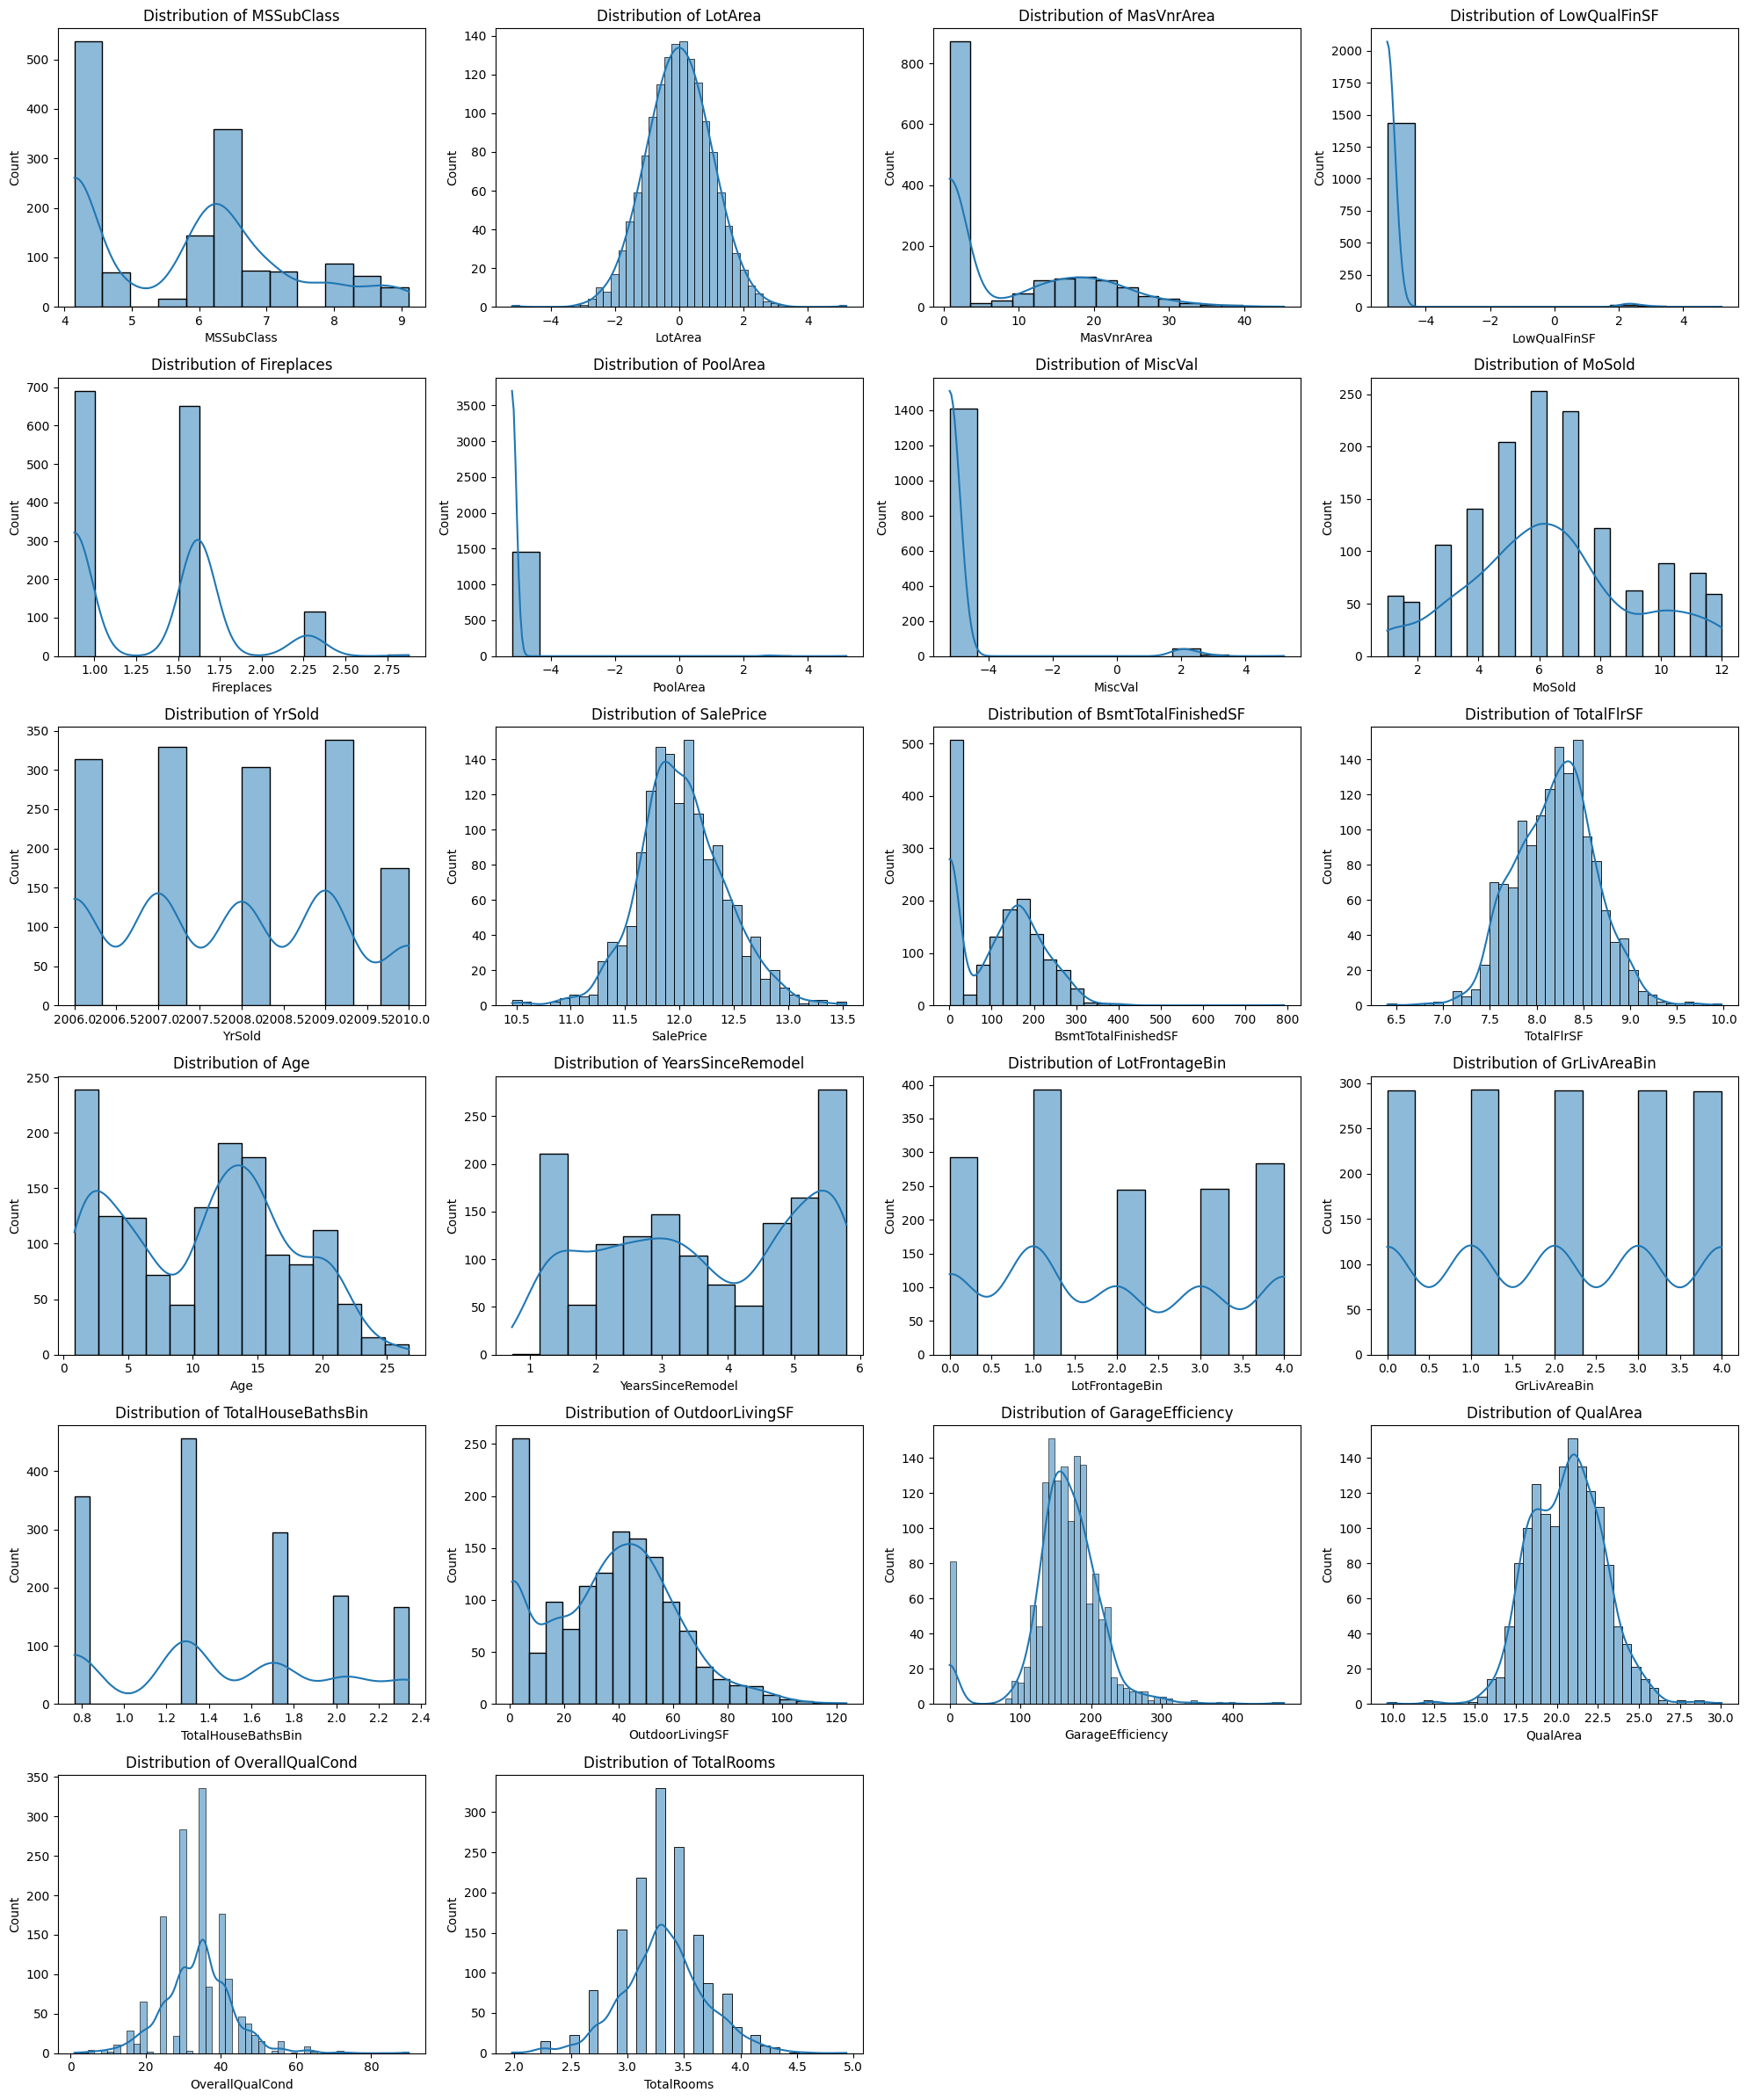

In [41]:
# Number of numeric features
num_features = len(numeric)

# Determine the layout of subplots
n_cols = 4  # Number of columns per row
n_rows = (num_features + n_cols - 1) // n_cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()  # Flatten to iterate easily

# Plot each numeric feature
for i, col in enumerate(numeric):
    sns.histplot(updated_df_final[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Selecting the important features before applying the one hot encoding**

In [42]:
# Here i am Creating a copy of Original Dataset , Which i will Used in Selecting TOp Best Features From Treebased Models .
df = updated_df_final.copy()
# Encoding Categorical Features Using Label Encoder Beacuse The model Will Raise Error if we give Cat Cols .
def encode (df):
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
    return df
df = encode(df)
#X and y 
X_rf = df.drop('SalePrice', axis=1)
y_rf = df['SalePrice']

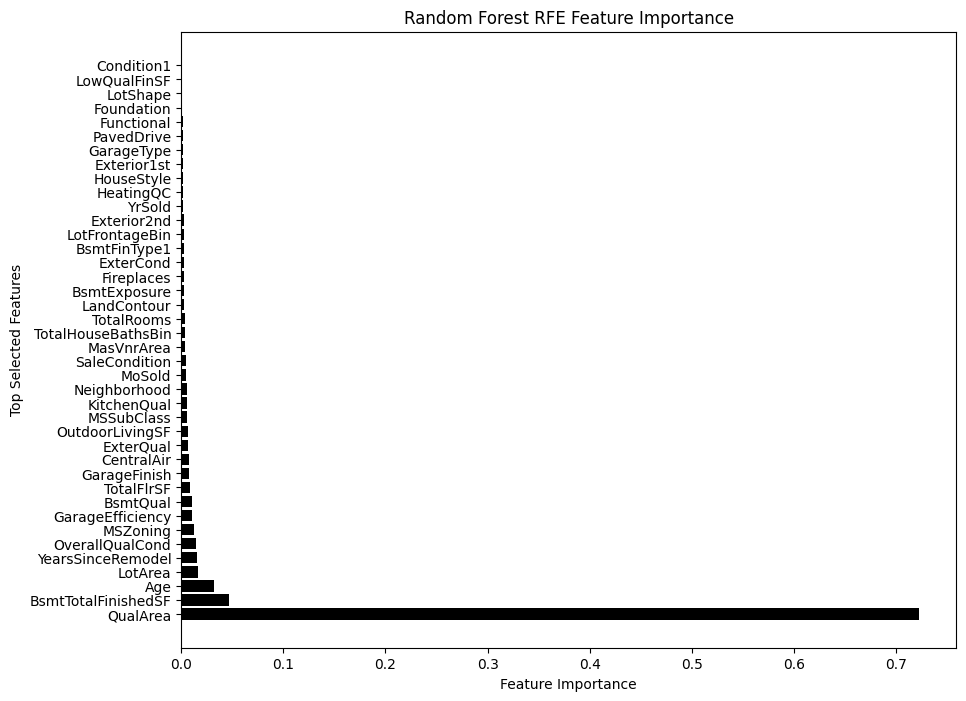

In [43]:
# Initialize RFE with the Random Forest model and number of features to select
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=50)

# Fit RFE to the training data
rfe.fit(X_rf, y_rf)

# Get the selected features
selected_features = X_rf.columns[rfe.support_]

# Train the Random Forest model with the selected features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf[selected_features], y_rf)

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Get the indices of the top selected features
top_selected_indices = feature_importances.argsort()[-40:][::-1]

# Get the names of the top selected features
top_selected_features = selected_features[top_selected_indices]

# Plotting the top selected features
plt.figure(figsize=(10, 8))
plt.barh(top_selected_features, feature_importances[top_selected_indices], color="black")
plt.xlabel('Feature Importance')
plt.ylabel('Top Selected Features')
plt.title('Random Forest RFE Feature Importance')
plt.show()

**Applying one hot encoding before fitting the data into the model**

In [44]:
top_selected_features_SP = top_selected_features.append(pd.Index(['SalePrice']))
top_selected_features_SP

Index(['QualArea', 'BsmtTotalFinishedSF', 'Age', 'LotArea',
       'YearsSinceRemodel', 'OverallQualCond', 'MSZoning', 'GarageEfficiency',
       'BsmtQual', 'TotalFlrSF', 'GarageFinish', 'CentralAir', 'ExterQual',
       'OutdoorLivingSF', 'MSSubClass', 'KitchenQual', 'Neighborhood',
       'MoSold', 'SaleCondition', 'MasVnrArea', 'TotalHouseBathsBin',
       'TotalRooms', 'LandContour', 'BsmtExposure', 'Fireplaces', 'ExterCond',
       'BsmtFinType1', 'LotFrontageBin', 'Exterior2nd', 'YrSold', 'HeatingQC',
       'HouseStyle', 'Exterior1st', 'GarageType', 'PavedDrive', 'Functional',
       'Foundation', 'LotShape', 'LowQualFinSF', 'Condition1', 'SalePrice'],
      dtype='object')

In [45]:
updated_df_final = updated_df_final[top_selected_features_SP]

In [46]:
updated_df_final = pd.get_dummies(updated_df_final).reset_index(drop=True)
updated_df_final.shape

(1460, 170)

**Training the models**

In [47]:
# Create X (features) by dropping the 'SalePrice' column
X = updated_df_final.drop(columns=['SalePrice'])

# Create y (target) by selecting the 'SalePrice' column
y = updated_df_final['SalePrice']

In [48]:
# Split the data (X and y) into train and test sets with 15% in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1314, 169)
X_test shape: (146, 169)
y_train shape: (1314,)
y_test shape: (146,)


In [49]:
# Setup cross validation folds
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

**Light Gradient Boosting Regressor**

In [50]:
# Define the model
lightlgb_model = LGBMRegressor(objective='regression', 
                                   random_state=42,
                                   n_estimators=300,
                                   num_leaves=5,
                                   bagging_freq=30,
                                   bagging_seed=8,
                                   verbose=-1)

In [51]:
# Fit the model
lightlgb_model.fit(X_train, y_train)

# Predict on training and test sets
y_pred_lgb = lightlgb_model.predict(X_test)

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

# Calculate R² Score
r2 = r2_score(y_test, y_pred_lgb)

# Print results
print(f"Test RMSE: {test_rmse}")
print(f"R² Score: {r2}")

Test RMSE: 0.12697218896769397
R² Score: 0.9177324526171617


**XG Boost Regressor**

In [52]:
# Define the XGBoost model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.02,
    n_estimators=10000,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [53]:
# Train the model
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='rmse',
              early_stopping_rounds=100,verbose=2000)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Calculate R² Score
r2 = r2_score(y_test, y_pred_xgb)

# Print results
print(f"Test RMSE: {test_rmse}")
print(f"R² Score: {r2}")

[0]	validation_0-rmse:0.43672


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[714]	validation_0-rmse:0.11138
Test RMSE: 0.11130182460170782
R² Score: 0.936785616873507


**Ridge regressor**

In [54]:
# Ridge Regressor
ridge_alphas = [7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 8, 10, 12, 15, 18, 20]
ridge_model = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfold))

In [55]:
# Fit the RidgeCV model (pipeline includes RobustScaler and RidgeCV)
ridge_model.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Calculate evaluation metrics
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_r2 = r2_score(y_test, y_pred_ridge)

# Print evaluation metrics
print(f"Ridge Regression RMSE: {ridge_rmse}")
print(f"Ridge Regression R^2 Score: {ridge_r2}")

# Get the best alpha selected by RidgeCV
best_alpha = ridge_model.named_steps['ridgecv'].alpha_
print(f"Best Alpha Selected by RidgeCV: {best_alpha}")


Ridge Regression RMSE: 0.11164825771982687
Ridge Regression R^2 Score: 0.9363914878872546
Best Alpha Selected by RidgeCV: 15.0


**Support Vector Model**

In [56]:
# Support Vector Regressor
svr_model = make_pipeline(RobustScaler(), SVR(C= 50, epsilon= 0.008, gamma=0.0003))

In [57]:
# Fit the SVR model (pipeline includes RobustScaler and SVR)
svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svr = svr_model.predict(X_test)

# Calculate evaluation metrics
svr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))
svr_r2 = r2_score(y_test, y_pred_svr)

# Print evaluation metrics
print(f"Support Vector Regressor RMSE: {svr_rmse}")
print(f"Support Vector Regressor R^2 Score: {svr_r2}")


Support Vector Regressor RMSE: 0.10415449702747137
Support Vector Regressor R^2 Score: 0.9446436574051338


**Random Forest Model**

In [58]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=7,
    min_samples_leaf=5,
    max_features=None,
    oob_score=True,
    random_state=42
)


In [59]:
# Fit the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Random Forest Regressor RMSE: {rf_rmse}")
print(f"Random Forest Regressor R^2 Score: {rf_r2}")

Random Forest Regressor RMSE: 0.13555490877746917
Random Forest Regressor R^2 Score: 0.9062347675498419


**Gradient Boost Regressor**

In [60]:
# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42) 

In [61]:
# Fit the model
gbr_model.fit(X_train, y_train)

# Predict on test data
y_pred_gbr = gbr_model.predict(X_test)

# Calculate evaluation metrics
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
gbr_r2 = r2_score(y_test, y_pred_gbr)

# Print evaluation metrics
print(f"Gradient Boost Regressor RMSE: {gbr_rmse}")
print(f"Gradient Boost Regressor R^2 Score: {gbr_r2}")

Gradient Boost Regressor RMSE: 0.12238284127151507
Gradient Boost Regressor R^2 Score: 0.9235720167428124


**Cat boost regressor**

In [62]:
cat_model = CatBoostRegressor(
    iterations=10000,         # Number of boosting iterations
    learning_rate=0.01,      # Learning rate
    depth=10,                # Depth of the tree
    l2_leaf_reg=3,           # L2 regularization coefficient
    eval_metric='RMSE',      # Metric to evaluate during training
    random_seed=42,          # Random seed for reproducibility
    verbose=2000,             # Verbose output every 100 iterations
    early_stopping_rounds=100  # Early stopping to prevent overfitting
)

In [63]:
# Fit the model
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Predict on test data
y_pred_cat = cat_model.predict(X_test)

# Calculate evaluation metrics
cat_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cat))
cat_r2 = r2_score(y_test, y_pred_cat)

# Print evaluation metrics
print(f"CatBoost Regressor RMSE: {cat_rmse}")
print(f"CatBoost Regressor R^2 Score: {cat_r2}")

0:	learn: 0.3915880	test: 0.4400221	best: 0.4400221 (0)	total: 89.2ms	remaining: 14m 51s
2000:	learn: 0.0315215	test: 0.1286843	best: 0.1286843 (2000)	total: 39.2s	remaining: 2m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1284641132
bestIteration = 2349

Shrink model to first 2350 iterations.
CatBoost Regressor RMSE: 0.12846409802083364
CatBoost Regressor R^2 Score: 0.915787825764518


In [64]:
lightlgb_full_data_model =  lightlgb_model.fit(X, y)
xgb_full_data_model = xgb_model
ridge_full_data_model = ridge_model.fit(X, y)
svr_full_data_model = svr_model
rf_full_data_model = rf_model.fit(X, y)
gbr_full_data_model = gbr_model.fit(X, y)
cat_full_data_model = cat_model

**Testing the model**

In [65]:
# Load the test data
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
# Dropping the id column
test_data = test_data.drop(['Id'], axis=1)
test_data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [66]:
# Checking the number of rows and columns
#Train
num_test_rows, num_test_columns = test_data.shape

#Printing the number of rows and columns.
print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

Test Data:
Number of Rows: 1459
Number of Columns: 79



* The number of columns in the training dataframe and the testing dataframe matches if we exclude the Salesprice column

**Preprocess Steps needs to be done**

* Filling the missing values

* Handling multicollinearity

* Handling the skew

* One hot encoding

In [67]:
null_check_df = pd.DataFrame(test_data.isnull().sum(), columns=['Null Count']).reset_index()
null_check_df.columns = ['Column', 'Null Count']
null_df = null_check_df[null_check_df['Null Count']>0]
null_df

,Column,Null Count
1,MSZoning,4
2,LotFrontage,227
5,Alley,1352
8,Utilities,2
22,Exterior1st,1
23,Exterior2nd,1
24,MasVnrType,894
25,MasVnrArea,15
29,BsmtQual,44
30,BsmtCond,45


In [68]:
# Dropping the columns that the model has not been trained with
updated_test_df = test_data.drop(['Alley', 'GarageYrBlt', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
updated_test_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal


In [69]:
# Get columns with missing values
missing_test_cols = updated_test_df.columns[updated_test_df.isnull().any()]

# Fill missing values for each column with mode grouped by 'HouseStyle'
for col in missing_test_cols:
    # Calculate the overall mode of the column
    col_mode = updated_test_df[col].mode().iloc[0] if not updated_test_df[col].mode().empty else None
    updated_test_df[col] = updated_test_df.groupby(['HouseStyle'])[col].transform(lambda group: fill_with_mode(group, col_mode))

# Display the first 3 rows of the updated DataFrame
updated_test_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal


In [70]:
# Check if there are any remaining missing values
updated_null_check = pd.DataFrame(updated_test_df.isnull().sum(), columns=['Null Count']).reset_index()
remaining_nulls = updated_null_check[updated_null_check['Null Count'] > 0]

# Output the result of columns with missing values
print(remaining_nulls)

Empty DataFrame
Columns: [index, Null Count]
Index: []


**Handling the multicollinearity columns**

In [71]:
updated_test_df.loc[:, "BsmtTotalFinishedSF"] = updated_test_df["BsmtFinSF1"] + updated_test_df["BsmtFinSF2"]

updated_test_df.loc[:, "TotalFlrSF"] = updated_test_df["1stFlrSF"] + updated_test_df["2ndFlrSF"]

updated_test_df.loc[:, "TotalHouseBaths"] = (updated_test_df["BsmtFullBath"] + (0.5 * updated_test_df["BsmtHalfBath"]) +
    updated_test_df["FullBath"] + (0.5 * updated_test_df["HalfBath"]))

updated_test_df.loc[:, "Age"] = updated_test_df["YrSold"] - updated_test_df["YearBuilt"]

updated_test_df.loc[:, "YearsSinceRemodel"] = updated_test_df["YrSold"] - updated_test_df["YearRemodAdd"]

updated_test_df.loc[:, "LotFrontageBin"] = pd.qcut(updated_test_df["LotFrontage"], q=5, labels=False)

updated_test_df.loc[:, "GrLivAreaBin"] = pd.qcut(updated_test_df["GrLivArea"], q=5, labels=False)

updated_test_df.loc[:, "TotalHouseBathsBin"] = pd.qcut(updated_test_df["TotalHouseBaths"], q=5, labels=False)

updated_test_df.loc[:, "OutdoorLivingSF"] = updated_test_df["WoodDeckSF"] + updated_test_df["OpenPorchSF"] + updated_test_df["EnclosedPorch"] + updated_test_df["3SsnPorch"] +updated_test_df["ScreenPorch"]

updated_test_df.loc[:, "GarageEfficiency"] = updated_test_df["GarageArea"] / (updated_test_df["GarageCars"] + 1)

updated_test_df.loc[:, "QualArea"] = updated_test_df["OverallQual"] * updated_test_df["GrLivArea"]

updated_test_df.loc[:, "OverallQualCond"] = updated_test_df["OverallQual"] * updated_test_df["OverallCond"]

updated_test_df.loc[:, "TotalRooms"] =updated_test_df["TotRmsAbvGrd"] + updated_test_df["BedroomAbvGr"] + updated_test_df["KitchenAbvGr"]

In [72]:
updated_test_df = updated_test_df.drop(["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"], axis=1)
updated_test_df = updated_test_df.drop(["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"], axis=1)
updated_test_df = updated_test_df.drop(["1stFlrSF", "2ndFlrSF"], axis=1)
updated_test_df = updated_test_df.drop("LotFrontage", axis=1)
updated_test_df = updated_test_df.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath","TotalHouseBaths"], axis=1)
updated_test_df = updated_test_df.drop(["GarageArea", "GarageCars"], axis=1)
updated_test_df = updated_test_df.drop(["YearBuilt", "YearRemodAdd"], axis=1)
updated_test_df = updated_test_df.drop(["OverallQual", "OverallCond","GrLivArea"], axis=1)
updated_test_df = updated_test_df.drop(["TotRmsAbvGrd", "BedroomAbvGr","KitchenAbvGr"], axis=1)

**Handling the skew**

In [73]:
# Fetch all numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in updated_test_df.columns:
    if updated_test_df[i].dtype in numeric_dtypes:
        numeric.append(i)

In [74]:
# Find skewed numerical features
skew_features = updated_test_df[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

# Check for features for skewness
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(15)

There are 14 numerical features with Skew > 0.5 :


PoolArea               20.176117
MiscVal                20.054543
LowQualFinSF           16.150628
LotArea                 3.112013
MasVnrArea              2.546947
OutdoorLivingSF         1.616050
QualArea                1.532678
MSSubClass              1.345305
TotalFlrSF              1.141459
BsmtTotalFinishedSF     0.955912
Fireplaces              0.819015
TotalRooms              0.807376
Age                     0.589056
TotalHouseBathsBin      0.508865
YearsSinceRemodel       0.399017
dtype: float64

In [75]:
# Thresholds for skewness classification
high_skew_threshold = 3  # Highly skewed
moderate_skew_threshold = 0.5  # Moderately skewed

# Separate features based on skewness thresholds
high_skew_features = skew_features[skew_features > high_skew_threshold].index
moderate_skew_features = skew_features[
    (skew_features > moderate_skew_threshold) & (skew_features <= high_skew_threshold)
].index

# Print the splits
print("Highly skewed features (Quantile Transformation):", high_skew_features.tolist())
print("Moderately skewed features (Box-Cox Transformation):", moderate_skew_features.tolist())

Highly skewed features (Quantile Transformation): ['PoolArea', 'MiscVal', 'LowQualFinSF', 'LotArea']
Moderately skewed features (Box-Cox Transformation): ['MasVnrArea', 'OutdoorLivingSF', 'QualArea', 'MSSubClass', 'TotalFlrSF', 'BsmtTotalFinishedSF', 'Fireplaces', 'TotalRooms', 'Age', 'TotalHouseBathsBin']


In [76]:
# Define a function for Quantile Transformation
def quantile_transform(data, cols, output_distribution='normal', random_state=42):
    qt = QuantileTransformer(output_distribution=output_distribution, random_state=random_state)
    for col in cols:
        if col in data.columns:
            data[col] = qt.fit_transform(data[[col]])
    return data

# Apply Quantile Transformation to highly skewed features
updated_test_df = quantile_transform(updated_test_df, high_skew_features)

# Apply Box-Cox Transformation to moderately skewed features
for col in moderate_skew_features:
    # Ensure column has positive values
    if (updated_test_df[col] <= 0).any():
        updated_test_df[col] = updated_test_df[col] - updated_test_df[col].min() + 1

    # Apply Box-Cox transformation
    try:
        optimal_lambda = boxcox_normmax(updated_test_df[col] + 1)
        updated_df_final[col] = boxcox1p(updated_test_df[col], optimal_lambda)
    except Exception as e:
        print(f"Skipping column '{col}' due to error: {e}")


Skipping column 'TotalFlrSF' due to error: The algorithm terminated without finding a valid bracket. Consider trying different initial points.


/opt/conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1317: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, prob = _stats_py.pearsonr(xvals, yvals)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


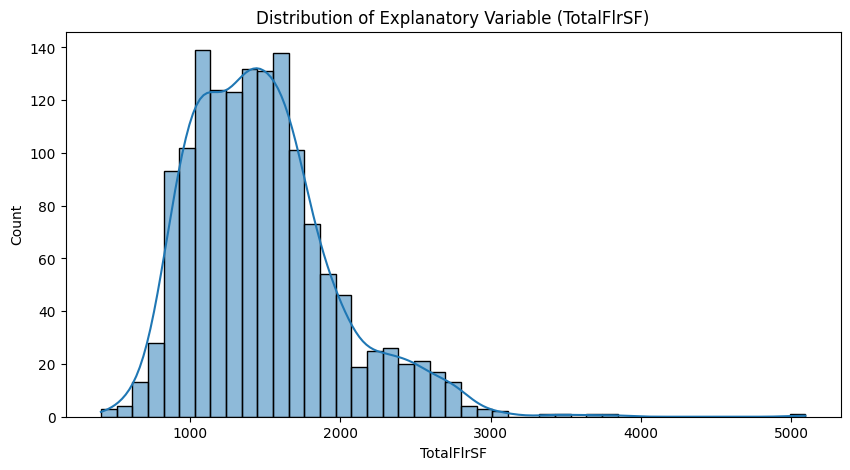

In [77]:
# # variable is '1stFlrSF'
# plt.figure(figsize=(10, 5))
# sns.histplot(updated_test_df['1stFlrSF'], kde=True)
# plt.title('Distribution of Explanatory Variable (1stFlrSF)')
# plt.show()

# variable is 'TotalFlrSF'
plt.figure(figsize=(10, 5))
sns.histplot(updated_test_df['TotalFlrSF'], kde=True)
plt.title('Distribution of Explanatory Variable (TotalFlrSF)')
plt.show()

# # variable is 'GrLivArea'
# plt.figure(figsize=(10, 5))
# sns.histplot(updated_test_df['GrLivArea'], kde=True)
# plt.title('Distribution of Explanatory Variable (GrLivArea)')
# plt.show()

In [78]:
# updated_test_df["1stFlrSF"] = np.log1p(updated_test_df["1stFlrSF"])

updated_test_df["TotalFlrSF"] = np.log1p(updated_test_df["TotalFlrSF"])

# updated_test_df["TotalFlrSF"] = np.log1p(updated_test_df["GrLivArea"])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

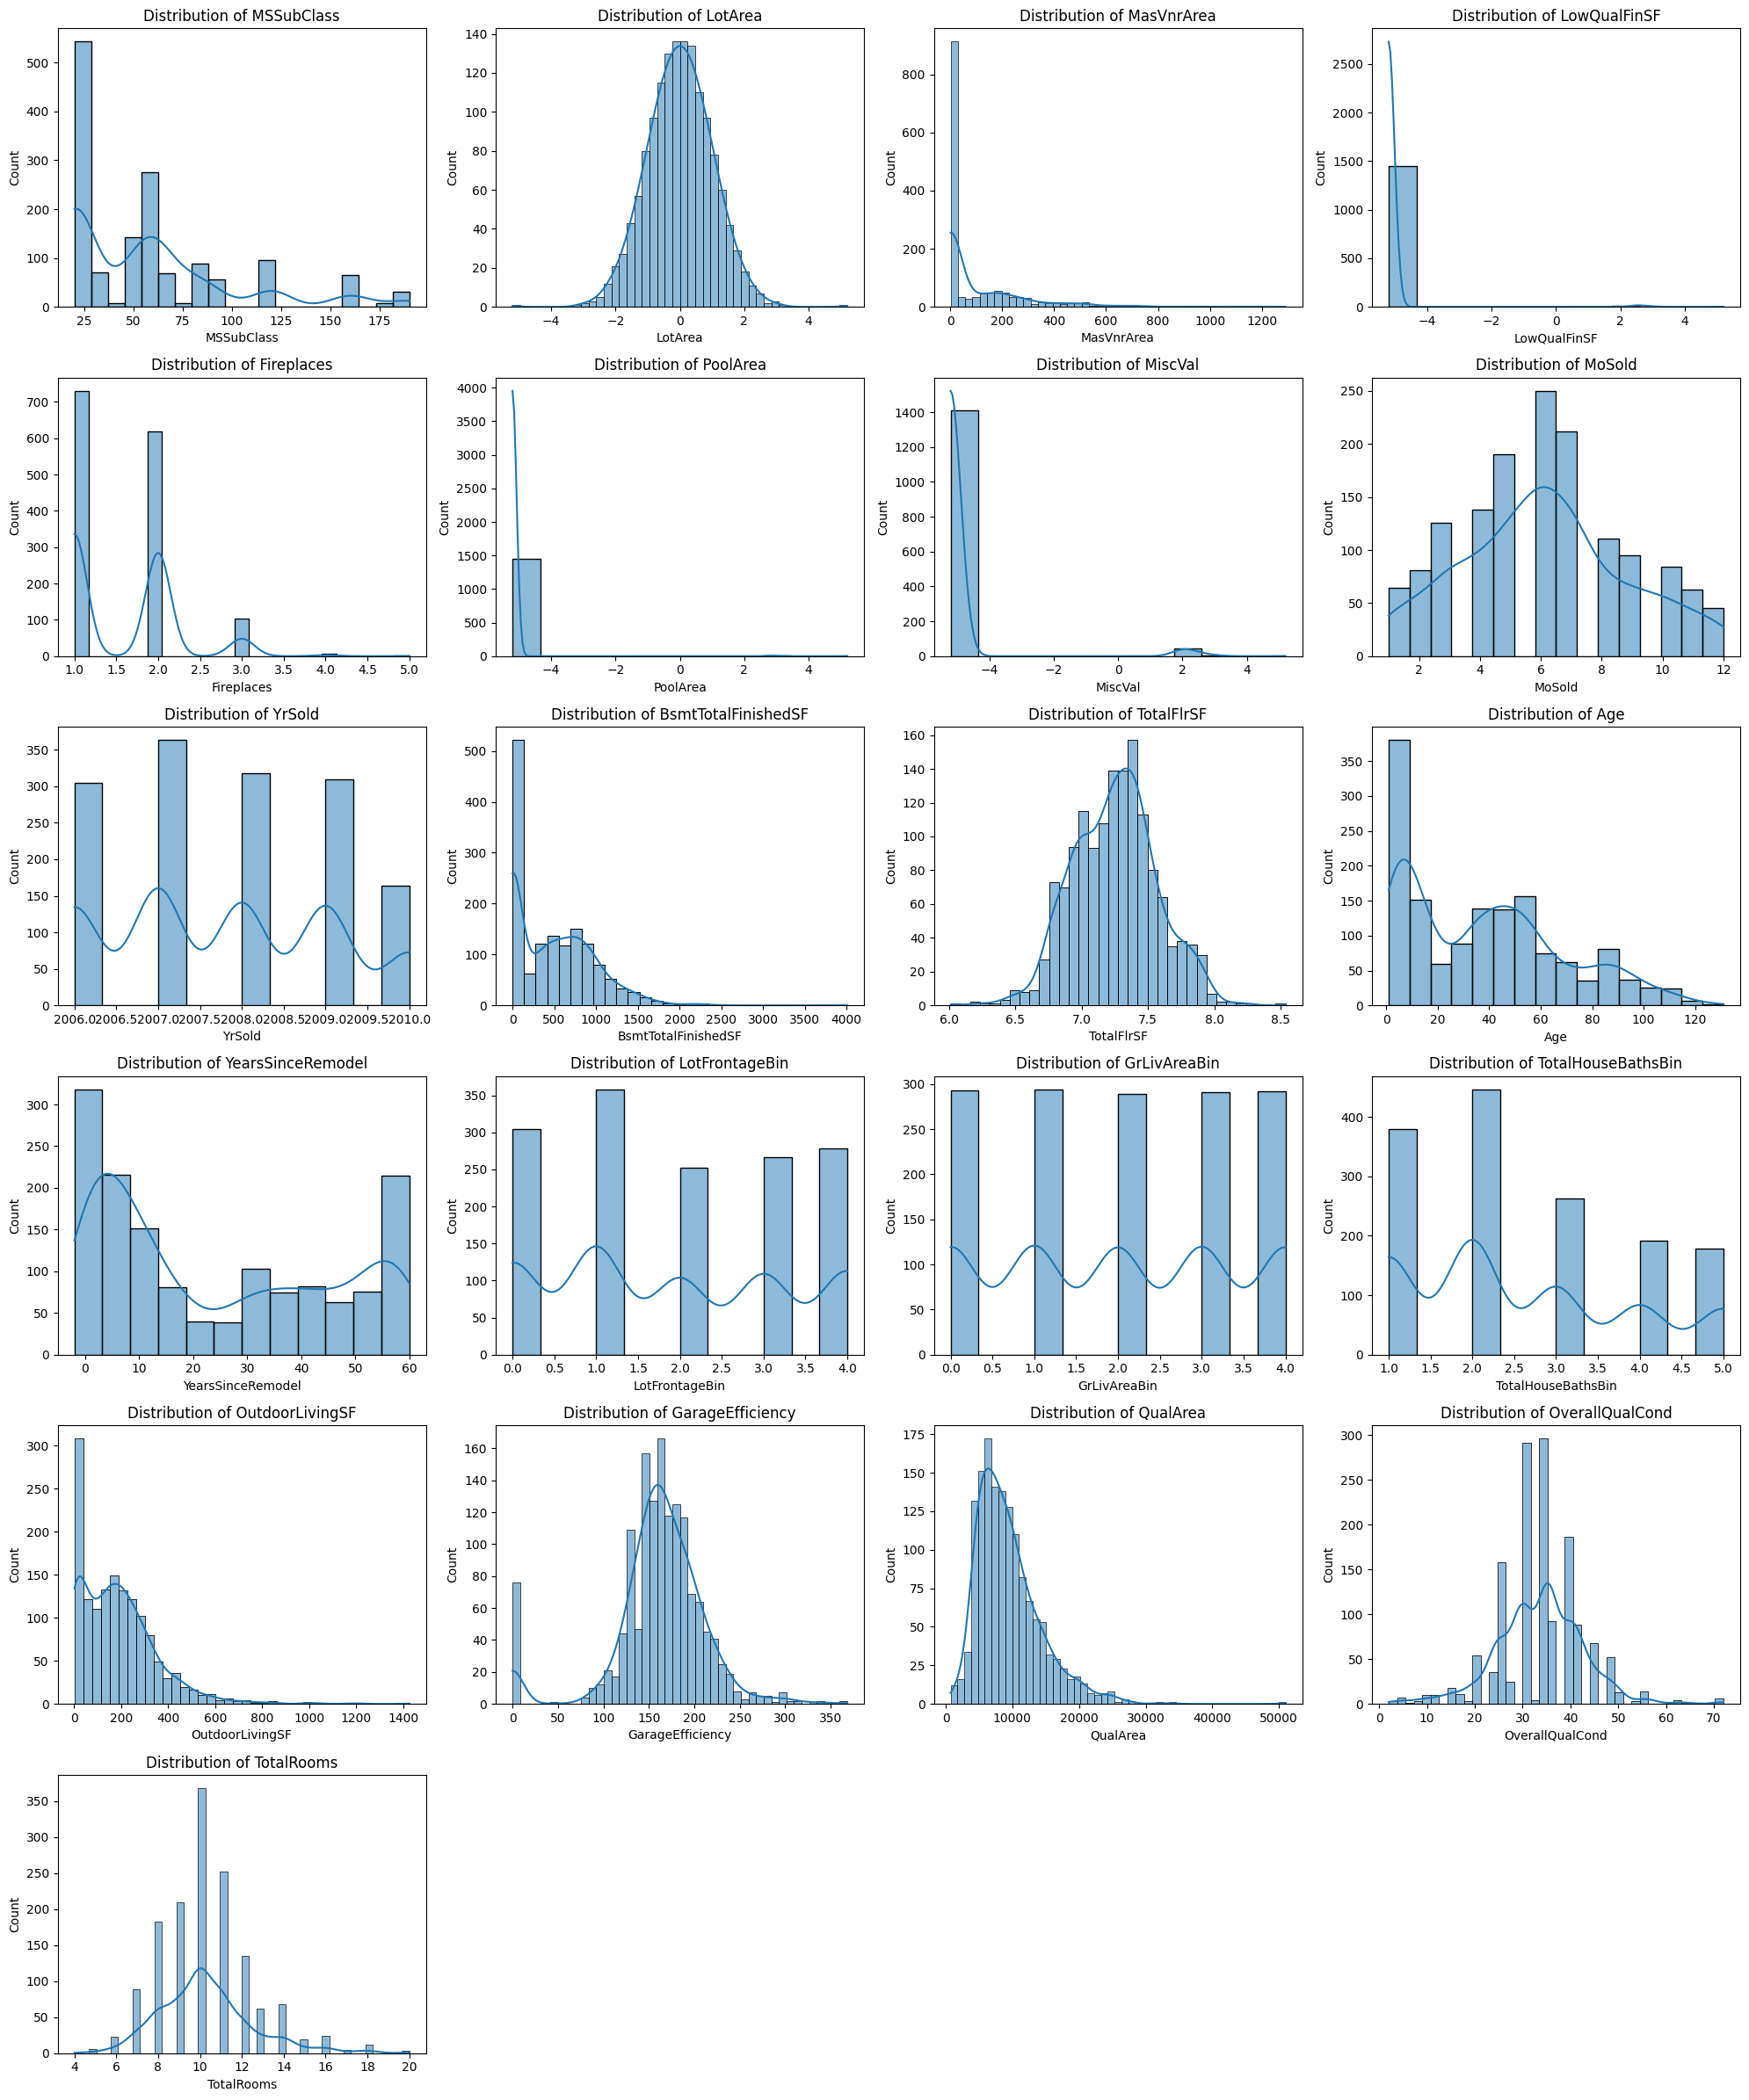

In [79]:
# Number of numeric features
num_features = len(numeric)

# Determine the layout of subplots
n_cols = 4  # Number of columns per row
n_rows = (num_features + n_cols - 1) // n_cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()  # Flatten to iterate easily

# Plot each numeric feature
for i, col in enumerate(numeric):
    sns.histplot(updated_test_df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Applying one hot encoding**

In [80]:
updated_test_df = updated_test_df[top_selected_features] 

In [81]:
updated_test_df = pd.get_dummies(updated_test_df).reset_index(drop=True)
updated_test_df.shape

(1459, 165)

In [82]:
# Align the test data columns to match the training data
updated_test_df = updated_test_df.reindex(columns=X.columns, fill_value=0)

# Verify shapes
print(X.shape)  # Training data shape
print(updated_test_df.shape)  # Test data shape (should match training data columns)

(1460, 169)
(1459, 169)


In [83]:
lightlgb_test_pred =  lightlgb_full_data_model.predict(updated_test_df)
lightlgb_actual_prices = np.floor(np.expm1(lightlgb_test_pred))

xgb_test_pred = xgb_full_data_model.predict(updated_test_df)
xgb_actual_prices = np.floor(np.expm1(xgb_test_pred))

ridge_test_pred = ridge_full_data_model.predict(updated_test_df)
ridge_actual_prices = np.floor(np.expm1(ridge_test_pred))

svr_test_pred = svr_full_data_model.predict(updated_test_df)
svr_actual_prices = np.floor(np.expm1(svr_test_pred))

rf_test_pred = rf_full_data_model.predict(updated_test_df)
rf_actual_prices = np.floor(np.expm1(rf_test_pred))

gbr_test_pred = gbr_full_data_model.predict(updated_test_df)
gbr_actual_prices = np.floor(np.expm1(gbr_test_pred))

cat_test_pred = cat_full_data_model.predict(updated_test_df)
cat_actual_prices = np.floor(np.expm1(cat_test_pred))

/tmp/ipykernel_30/2989123947.py:8: RuntimeWarning: overflow encountered in expm1
  ridge_actual_prices = np.floor(np.expm1(ridge_test_pred))


In [84]:
# Replace these placeholders with your actual arrays
rf_actual_prices = rf_actual_prices/2

In [85]:
# Replace these placeholders with your actual arrays
lightlgb_actual_prices = np.array(lightlgb_actual_prices)
xgb_actual_prices = np.array(xgb_actual_prices)
svr_actual_prices = np.array(svr_actual_prices)
rf_actual_prices = np.array(rf_actual_prices)
gbr_actual_prices = np.array(gbr_actual_prices)
cat_actual_prices = np.array(cat_actual_prices)

In [86]:
# Stack all the arrays into a single NumPy array
all_predictions = np.stack([
    rf_actual_prices,
    svr_actual_prices,
    gbr_actual_prices,
    cat_actual_prices
])

In [87]:
# Compute the mean along the rows (axis=0)
mean_predictions = np.mean(all_predictions, axis=0)

In [88]:
def blended_predictions(X):
    return ((0.1 * svr_model.predict(X)) + 
            (0.2 * gbr_model.predict(X)) + 
            (0.2 * xgb_model.predict(X)) + 
            (0.2 * lightlgb_model.predict(X)) + 
            (0.1 * rf_model.predict(X)) + 
            (0.2 * cat_model.predict(X)))

In [89]:
# Generate blended predictions for test data
blended_preds = blended_predictions(updated_test_df)
blended_actual_prices = np.floor(np.expm1(blended_preds))
blended_actual_prices

array([177708., 201316., 224746., ..., 212607., 187411., 229888.])

In [90]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = blended_actual_prices

In [91]:
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,Id,SalePrice
0,1461,177708.0
1,1462,201316.0
2,1463,224746.0
3,1464,234003.0
4,1465,208910.0
